In [2]:
'''
    A set of functions which implement the Marine Heat Wave (MHW)
    definition of Hobday et al. (2016)
'''


import numpy as np
import scipy as sp
from scipy import linalg
from scipy import stats
import scipy.ndimage as ndimage
from datetime import date


def detect(t, temp, climatologyPeriod=[None,None], pctile=90, windowHalfWidth=5, smoothPercentile=True, smoothPercentileWidth=31, minDuration=5, joinAcrossGaps=True, maxGap=2, maxPadLength=False, coldSpells=False, alternateClimatology=False, Ly=False):
    '''
    Applies the Hobday et al. (2016) marine heat wave definition to an input time
    series of temp ('temp') along with a time vector ('t'). Outputs properties of
    all detected marine heat waves.
    Inputs:
      t       Time vector, in datetime format (e.g., date(1982,1,1).toordinal())
              [1D numpy array of length T]
      temp    Temperature vector [1D numpy array of length T]
    Outputs:
      mhw     Detected marine heat waves (MHWs). Each key (following list) is a
              list of length N where N is the number of detected MHWs:
 
        'time_start'           Start time of MHW [datetime format] # MHW开始的时间
        'time_end'             End time of MHW [datetime format]  # MHW结束的时间
        'time_peak'            Time of MHW peak [datetime format] # MHW的峰值时间
        'date_start'           Start date of MHW [datetime format]  # MHW开始的日期
        'date_end'             End date of MHW [datetime format]   # MHW结束的日期
        'date_peak'            Date of MHW peak [datetime format] # MHW峰值的时间
        'index_start'          Start index of MHW #MHW开始的索引
        'index_end'            End index of MHW  #MHW结束的索引
        'index_peak'           Index of MHW peak #MHW峰值的索引
        'duration'             Duration of MHW [days] #MHW经历的日期
        'intensity_max'        Maximum (peak) intensity [deg. C]  # 最大强度
        'intensity_mean'       Mean intensity [deg. C] #平均强度
        'intensity_var'        Intensity variability [deg. C] # 
        'intensity_cumulative' Cumulative intensity [deg. C x days] #累积强度
        'rate_onset'           Onset rate of MHW [deg. C / days] # MHW的增长率
        'rate_decline'         Decline rate of MHW [deg. C / days]
        'intensity_max_relThresh', 'intensity_mean_relThresh', 'intensity_var_relThresh', 
        and 'intensity_cumulative_relThresh' are as above except relative to the
        threshold (e.g., 90th percentile) rather than the seasonal climatology
        'intensity_max_abs', 'intensity_mean_abs', 'intensity_var_abs', and
        'intensity_cumulative_abs' are as above except as absolute magnitudes
        rather than relative to the seasonal climatology or threshold
        'category' is an integer category system (1, 2, 3, 4) based on the maximum intensity
        in multiples of threshold exceedances, i.e., a value of 1 indicates the MHW
        intensity (relative to the climatology) was >=1 times the value of the threshold (but
        less than 2 times; relative to climatology, i.e., threshold - climatology).
        Category types are defined as 1=moderate, 2=strong, 3=severe, 4=extreme. More details in
        Hobday et al. (in prep., Oceanography). Also supplied are the duration of each of these
        categories for each event.  #这些相对于阈值而不是相对于气候态
        'n_events'             A scalar integer (not a list) indicating the total
                               number of detected MHW events  # 发生了几次MHW事件
      clim    Climatology of SST. Each key (following list) is a seasonally-varying
              time series [1D numpy array of length T] of a particular measure:  # 海温的气候学
        'thresh'               Seasonally varying threshold (e.g., 90th percentile) # 季节性变化的阈值 （例如 90百分位数）
        'seas'                 Climatological seasonal cycle  # 气候季节循环
        'missing'              A vector of TRUE/FALSE indicating which elements in 
                               temp were missing values for the MHWs detection
    Options:
      climatologyPeriod      Period over which climatology is calculated, specified
                             as list of start and end years. Default is to calculate
                             over the full range of years in the supplied time series.
                             Alternate periods suppled as a list e.g. [1983,2012].
      pctile                 Threshold percentile (%) for detection of extreme values
                             (DEFAULT = 90)
      windowHalfWidth        Width of window (one sided) about day-of-year used for
                             the pooling of values and calculation of threshold percentile
                             (DEFAULT = 5 [days])
      smoothPercentile       Boolean switch indicating whether to smooth the threshold
                             percentile timeseries with a moving average (DEFAULT = True)
      smoothPercentileWidth  Width of moving average window for smoothing threshold
                             (DEFAULT = 31 [days])
      minDuration            Minimum duration for acceptance detected MHWs
                             (DEFAULT = 5 [days])
      joinAcrossGaps         Boolean switch indicating whether to join MHWs
                             which occur before/after a short gap (DEFAULT = True)
      maxGap                 Maximum length of gap allowed for the joining of MHWs
                             (DEFAULT = 2 [days])
      maxPadLength           Specifies the maximum length [days] over which to interpolate
                             (pad) missing data (specified as nans) in input temp time series.
                             i.e., any consecutive blocks of NaNs with length greater
                             than maxPadLength will be left as NaN. Set as an integer.
                             (DEFAULT = False, interpolates over all missing values).
      coldSpells             Specifies if the code should detect cold events instead of
                             heat events. (DEFAULT = False)
      alternateClimatology   Specifies an alternate temperature time series to use for the
                             calculation of the climatology. Format is as a list of numpy
                             arrays: (1) the first element of the list is a time vector,
                             in datetime format (e.g., date(1982,1,1).toordinal())
                             [1D numpy array of length TClim] and (2) the second element of
                             the list is a temperature vector [1D numpy array of length TClim].
                             (DEFAULT = False)
      Ly                     Specifies if the length of the year is < 365/366 days (e.g. a 
                             360 day year from a climate model). This affects the calculation
                             of the climatology. (DEFAULT = False)
    Notes:
      1. This function assumes that the input time series consist of continuous daily values
         with few missing values. Time ranges which start and end part-way through the calendar
         year are supported.
      2. This function supports leap years. This is done by ignoring Feb 29s for the initial
         calculation of the climatology and threshold. The value of these for Feb 29 is then
         linearly interpolated from the values for Feb 28 and Mar 1.
      3. The calculation of onset and decline rates assumes that the heat wave started a half-day
         before the start day and ended a half-day after the end-day. (This is consistent with the
         duration definition as implemented, which assumes duration = end day - start day + 1.)
      4. For the purposes of MHW detection, any missing temp values not interpolated over (through
         optional maxPadLLength) will be set equal to the seasonal climatology. This means they will
         trigger the end/start of any adjacent temp values which satisfy the MHW criteria.
      5. If the code is used to detect cold events (coldSpells = True), then it works just as for heat
         waves except that events are detected as deviations below the (100 - pctile)th percentile
         (e.g., the 10th instead of 90th) for at least 5 days. Intensities are reported as negative
         values and represent the temperature anomaly below climatology.
    Written by Eric Oliver, Institue for Marine and Antarctic Studies, University of Tasmania, Feb 2015
    '''

    #
    # Initialize MHW output variable
    #

    mhw = {}
    mhw['time_start'] = [] # datetime format
    mhw['time_end'] = [] # datetime format
    mhw['time_peak'] = [] # datetime format
    mhw['date_start'] = [] # datetime format
    mhw['date_end'] = [] # datetime format
    mhw['date_peak'] = [] # datetime format
    mhw['index_start'] = []
    mhw['index_end'] = []
    mhw['index_peak'] = []
    mhw['duration'] = [] # [days]
    mhw['duration_moderate'] = [] # [days]
    mhw['duration_strong'] = [] # [days]
    mhw['duration_severe'] = [] # [days]
    mhw['duration_extreme'] = [] # [days]
    mhw['intensity_max'] = [] # [deg C]
    mhw['intensity_mean'] = [] # [deg C]
    mhw['intensity_var'] = [] # [deg C]
    mhw['intensity_cumulative'] = [] # [deg C]
    mhw['intensity_max_relThresh'] = [] # [deg C]
    mhw['intensity_mean_relThresh'] = [] # [deg C]
    mhw['intensity_var_relThresh'] = [] # [deg C]
    mhw['intensity_cumulative_relThresh'] = [] # [deg C]
    mhw['intensity_max_abs'] = [] # [deg C]
    mhw['intensity_mean_abs'] = [] # [deg C]
    mhw['intensity_var_abs'] = [] # [deg C]
    mhw['intensity_cumulative_abs'] = [] # [deg C]
    mhw['category'] = []
    mhw['rate_onset'] = [] # [deg C / day]
    mhw['rate_decline'] = [] # [deg C / day]

    #
    # Time and dates vectors
    #

    # Generate vectors for year, month, day-of-month, and day-of-year
    T = len(t)
    year = np.zeros((T))
    month = np.zeros((T))
    day = np.zeros((T))
    doy = np.zeros((T))
    for i in range(T):
        year[i] = date.fromordinal(t[i]).year
        month[i] = date.fromordinal(t[i]).month
        day[i] = date.fromordinal(t[i]).day
    # Leap-year baseline for defining day-of-year values
    year_leapYear = 2012 # This year was a leap-year and therefore doy in range of 1 to 366
    t_leapYear = np.arange(date(year_leapYear, 1, 1).toordinal(),date(year_leapYear, 12, 31).toordinal()+1)
    dates_leapYear = [date.fromordinal(tt.astype(int)) for tt in t_leapYear]
    month_leapYear = np.zeros((len(t_leapYear)))
    day_leapYear = np.zeros((len(t_leapYear)))
    doy_leapYear = np.zeros((len(t_leapYear)))
    for tt in range(len(t_leapYear)):
        month_leapYear[tt] = date.fromordinal(t_leapYear[tt]).month
        day_leapYear[tt] = date.fromordinal(t_leapYear[tt]).day
        doy_leapYear[tt] = t_leapYear[tt] - date(date.fromordinal(t_leapYear[tt]).year,1,1).toordinal() + 1
        
    # Calculate day-of-year values
    for tt in range(T):
        doy[tt] = doy_leapYear[(month_leapYear == month[tt]) * (day_leapYear == day[tt])]

    # Constants (doy values for Feb-28 and Feb-29) for handling leap-years
    feb28 = 59
    feb29 = 60

    # Set climatology period, if unset use full range of available data
    if (climatologyPeriod[0] is None) or (climatologyPeriod[1] is None):
        climatologyPeriod[0] = year[0]
        climatologyPeriod[1] = year[-1]

    #
    # Calculate threshold and seasonal climatology (varying with day-of-year)
    #

    # if alternate temperature time series is supplied for the calculation of the climatology
    if alternateClimatology:
        tClim = alternateClimatology[0]
        tempClim = alternateClimatology[1]
        TClim = len(tClim)
        yearClim = np.zeros((TClim))
        monthClim = np.zeros((TClim))
        dayClim = np.zeros((TClim))
        doyClim = np.zeros((TClim))
        for i in range(TClim):
            yearClim[i] = date.fromordinal(tClim[i]).year
            monthClim[i] = date.fromordinal(tClim[i]).month
            dayClim[i] = date.fromordinal(tClim[i]).day
            doyClim[i] = doy_leapYear[(month_leapYear == monthClim[i]) * (day_leapYear == dayClim[i])]
    else:
        tempClim = temp.copy()
        TClim = np.array([T]).copy()[0]
        yearClim = year.copy()
        monthClim = month.copy()
        dayClim = day.copy()
        doyClim = doy.copy()

    # Flip temp time series if detecting cold spells
    if coldSpells:
        temp = -1.*temp
        tempClim = -1.*tempClim

    # Pad missing values for all consecutive missing blocks of length <= maxPadLength
    if maxPadLength:
        temp = pad(temp, maxPadLength=maxPadLength)
        tempClim = pad(tempClim, maxPadLength=maxPadLength)

    # Length of climatological year
    lenClimYear = 366
    # Start and end indices
    clim_start = np.where(yearClim == climatologyPeriod[0])[0][0]
    clim_end = np.where(yearClim == climatologyPeriod[1])[0][-1]
    # Inialize arrays
    thresh_climYear = np.NaN*np.zeros(lenClimYear)
    seas_climYear = np.NaN*np.zeros(lenClimYear)
    clim = {}
    clim['thresh'] = np.NaN*np.zeros(TClim)
    clim['seas'] = np.NaN*np.zeros(TClim)
    # Loop over all day-of-year values, and calculate threshold and seasonal climatology across years
    for d in range(1,lenClimYear+1):
        # Special case for Feb 29
        if d == feb29:
            continue
        # find all indices for each day of the year +/- windowHalfWidth and from them calculate the threshold
        tt0 = np.where(doyClim[clim_start:clim_end+1] == d)[0] 
        # If this doy value does not exist (i.e. in 360-day calendars) then skip it
        if len(tt0) == 0:
            continue
        tt = np.array([])
        for w in range(-windowHalfWidth, windowHalfWidth+1):
            tt = np.append(tt, clim_start+tt0 + w)
        tt = tt[tt>=0] # Reject indices "before" the first element
        tt = tt[tt<TClim] # Reject indices "after" the last element
        thresh_climYear[d-1] = np.nanpercentile(tempClim[tt.astype(int)], pctile)
        seas_climYear[d-1] = np.nanmean(tempClim[tt.astype(int)])
    # Special case for Feb 29
    thresh_climYear[feb29-1] = 0.5*thresh_climYear[feb29-2] + 0.5*thresh_climYear[feb29]
    seas_climYear[feb29-1] = 0.5*seas_climYear[feb29-2] + 0.5*seas_climYear[feb29]

    # Smooth if desired
    if smoothPercentile:
        # If the length of year is < 365/366 (e.g. a 360 day year from a Climate Model)
        if Ly:
            valid = ~np.isnan(thresh_climYear)
            thresh_climYear[valid] = runavg(thresh_climYear[valid], smoothPercentileWidth)
            valid = ~np.isnan(seas_climYear)
            seas_climYear[valid] = runavg(seas_climYear[valid], smoothPercentileWidth)
        # >= 365-day year
        else:
            thresh_climYear = runavg(thresh_climYear, smoothPercentileWidth)
            seas_climYear = runavg(seas_climYear, smoothPercentileWidth)

    # Generate threshold for full time series
    clim['thresh'] = thresh_climYear[doy.astype(int)-1]
    clim['seas'] = seas_climYear[doy.astype(int)-1]

    # Save vector indicating which points in temp are missing values
    clim['missing'] = np.isnan(temp)
    # Set all remaining missing temp values equal to the climatology
    temp[np.isnan(temp)] = clim['seas'][np.isnan(temp)]

    #
    # Find MHWs as exceedances above the threshold
    #

    # Time series of "True" when threshold is exceeded, "False" otherwise
    exceed_bool = temp - clim['thresh']
    exceed_bool[exceed_bool<=0] = False
    exceed_bool[exceed_bool>0] = True
    # Fix issue where missing temp vaues (nan) are counted as True
    exceed_bool[np.isnan(exceed_bool)] = False
    # Find contiguous regions of exceed_bool = True
    events, n_events = ndimage.label(exceed_bool)

    # Find all MHW events of duration >= minDuration
    for ev in range(1,n_events+1):
        event_duration = (events == ev).sum()
        if event_duration < minDuration:
            continue
        mhw['time_start'].append(t[np.where(events == ev)[0][0]])
        mhw['time_end'].append(t[np.where(events == ev)[0][-1]])

    # Link heat waves that occur before and after a short gap (gap must be no longer than maxGap)
    if joinAcrossGaps:
        # Calculate gap length for each consecutive pair of events
        gaps = np.array(mhw['time_start'][1:]) - np.array(mhw['time_end'][0:-1]) - 1
        if len(gaps) > 0:
            while gaps.min() <= maxGap:
                # Find first short gap
                ev = np.where(gaps <= maxGap)[0][0]
                # Extend first MHW to encompass second MHW (including gap)
                mhw['time_end'][ev] = mhw['time_end'][ev+1]
                # Remove second event from record
                del mhw['time_start'][ev+1]
                del mhw['time_end'][ev+1]
                # Calculate gap length for each consecutive pair of events
                gaps = np.array(mhw['time_start'][1:]) - np.array(mhw['time_end'][0:-1]) - 1
                if len(gaps) == 0:
                    break

    # Calculate marine heat wave properties
    mhw['n_events'] = len(mhw['time_start'])
    categories = np.array(['Moderate', 'Strong', 'Severe', 'Extreme'])
    for ev in range(mhw['n_events']):
        mhw['date_start'].append(date.fromordinal(mhw['time_start'][ev]))
        mhw['date_end'].append(date.fromordinal(mhw['time_end'][ev]))
        # Get SST series during MHW event, relative to both threshold and to seasonal climatology
        tt_start = np.where(t==mhw['time_start'][ev])[0][0]
        tt_end = np.where(t==mhw['time_end'][ev])[0][0]
        mhw['index_start'].append(tt_start)
        mhw['index_end'].append(tt_end)
        temp_mhw = temp[tt_start:tt_end+1]
        thresh_mhw = clim['thresh'][tt_start:tt_end+1]
        seas_mhw = clim['seas'][tt_start:tt_end+1]
        mhw_relSeas = temp_mhw - seas_mhw
        mhw_relThresh = temp_mhw - thresh_mhw
        mhw_relThreshNorm = (temp_mhw - thresh_mhw) / (thresh_mhw - seas_mhw)
        mhw_abs = temp_mhw
        # Find peak
        tt_peak = np.argmax(mhw_relSeas)
        mhw['time_peak'].append(mhw['time_start'][ev] + tt_peak)
        mhw['date_peak'].append(date.fromordinal(mhw['time_start'][ev] + tt_peak))
        mhw['index_peak'].append(tt_start + tt_peak)
        # MHW Duration
        mhw['duration'].append(len(mhw_relSeas))
        # MHW Intensity metrics
        mhw['intensity_max'].append(mhw_relSeas[tt_peak])
        mhw['intensity_mean'].append(mhw_relSeas.mean())
        mhw['intensity_var'].append(np.sqrt(mhw_relSeas.var()))
        mhw['intensity_cumulative'].append(mhw_relSeas.sum())
        mhw['intensity_max_relThresh'].append(mhw_relThresh[tt_peak])
        mhw['intensity_mean_relThresh'].append(mhw_relThresh.mean())
        mhw['intensity_var_relThresh'].append(np.sqrt(mhw_relThresh.var()))
        mhw['intensity_cumulative_relThresh'].append(mhw_relThresh.sum())
        mhw['intensity_max_abs'].append(mhw_abs[tt_peak])
        mhw['intensity_mean_abs'].append(mhw_abs.mean())
        mhw['intensity_var_abs'].append(np.sqrt(mhw_abs.var()))
        mhw['intensity_cumulative_abs'].append(mhw_abs.sum())
        # Fix categories
        tt_peakCat = np.argmax(mhw_relThreshNorm)
        cats = np.floor(1. + mhw_relThreshNorm)
        mhw['category'].append(categories[np.min([cats[tt_peakCat], 4]).astype(int) - 1])
        mhw['duration_moderate'].append(np.sum(cats == 1.))
        mhw['duration_strong'].append(np.sum(cats == 2.))
        mhw['duration_severe'].append(np.sum(cats == 3.))
        mhw['duration_extreme'].append(np.sum(cats >= 4.))
        
        # Rates of onset and decline
        # Requires getting MHW strength at "start" and "end" of event (continuous: assume start/end half-day before/after first/last point)
        if tt_start > 0:
            mhw_relSeas_start = 0.5*(mhw_relSeas[0] + temp[tt_start-1] - clim['seas'][tt_start-1])
            mhw['rate_onset'].append((mhw_relSeas[tt_peak] - mhw_relSeas_start) / (tt_peak+0.5))
        else: # MHW starts at beginning of time series
            if tt_peak == 0: # Peak is also at begining of time series, assume onset time = 1 day
                mhw['rate_onset'].append((mhw_relSeas[tt_peak] - mhw_relSeas[0]) / 1.)
            else:
                mhw['rate_onset'].append((mhw_relSeas[tt_peak] - mhw_relSeas[0]) / tt_peak)
        if tt_end < T-1:
            mhw_relSeas_end = 0.5*(mhw_relSeas[-1] + temp[tt_end+1] - clim['seas'][tt_end+1])
            mhw['rate_decline'].append((mhw_relSeas[tt_peak] - mhw_relSeas_end) / (tt_end-tt_start-tt_peak+0.5))
        else: # MHW finishes at end of time series
            if tt_peak == T-1: # Peak is also at end of time series, assume decline time = 1 day
                mhw['rate_decline'].append((mhw_relSeas[tt_peak] - mhw_relSeas[-1]) / 1.)
            else:
                mhw['rate_decline'].append((mhw_relSeas[tt_peak] - mhw_relSeas[-1]) / (tt_end-tt_start-tt_peak))

    # Flip climatology and intensties in case of cold spell detection
    if coldSpells:
        clim['seas'] = -1.*clim['seas']
        clim['thresh'] = -1.*clim['thresh']
        for ev in range(len(mhw['intensity_max'])):
            mhw['intensity_max'][ev] = -1.*mhw['intensity_max'][ev]
            mhw['intensity_mean'][ev] = -1.*mhw['intensity_mean'][ev]
            mhw['intensity_cumulative'][ev] = -1.*mhw['intensity_cumulative'][ev]
            mhw['intensity_max_relThresh'][ev] = -1.*mhw['intensity_max_relThresh'][ev]
            mhw['intensity_mean_relThresh'][ev] = -1.*mhw['intensity_mean_relThresh'][ev]
            mhw['intensity_cumulative_relThresh'][ev] = -1.*mhw['intensity_cumulative_relThresh'][ev]
            mhw['intensity_max_abs'][ev] = -1.*mhw['intensity_max_abs'][ev]
            mhw['intensity_mean_abs'][ev] = -1.*mhw['intensity_mean_abs'][ev]
            mhw['intensity_cumulative_abs'][ev] = -1.*mhw['intensity_cumulative_abs'][ev]

    return mhw, clim


def blockAverage(t, mhw, clim=None, blockLength=1, removeMissing=False, temp=None):
    '''
    Calculate statistics of marine heatwave (MHW) properties averaged over blocks of
    a specified length of time. Takes as input a collection of detected MHWs
    (using the marineHeatWaves.detect function) and a time vector for the source
    SST series.
    Inputs:
      t       Time vector, in datetime format (e.g., date(1982,1,1).toordinal())
      mhw     Marine heat waves (MHWs) detected using marineHeatWaves.detect
    Outputs:
      mhwBlock   Time series of block-averaged MHW properties. Each key (following list)
                 is a list of length N where N is the number of blocks:
 
        'years_start'          Start year blocks (inclusive)
        'years_end'            End year of blocks (inclusive)
        'years_centre'         Decimal year at centre of blocks
        'count'                Total MHW count in each block
        'duration'             Average MHW duration in each block [days]
        'intensity_max'        Average MHW "maximum (peak) intensity" in each block [deg. C]
        'intensity_max_max'    Maximum MHW "maximum (peak) intensity" in each block [deg. C]
        'intensity_mean'       Average MHW "mean intensity" in each block [deg. C]
        'intensity_var'        Average MHW "intensity variability" in each block [deg. C]
        'intensity_cumulative' Average MHW "cumulative intensity" in each block [deg. C x days]
        'rate_onset'           Average MHW onset rate in each block [deg. C / days]
        'rate_decline'         Average MHW decline rate in each block [deg. C / days]
        'total_days'           Total number of MHW days in each block [days]
        'total_icum'           Total cumulative intensity over all MHWs in each block [deg. C x days]
        'intensity_max_relThresh', 'intensity_mean_relThresh', 'intensity_var_relThresh', 
        and 'intensity_cumulative_relThresh' are as above except relative to the
        threshold (e.g., 90th percentile) rather than the seasonal climatology
        'intensity_max_abs', 'intensity_mean_abs', 'intensity_var_abs', and
        'intensity_cumulative_abs' are as above except as absolute magnitudes
        rather than relative to the seasonal climatology or threshold
    Options:
      blockLength            Size of block (in years) over which to calculate the
                             averaged MHW properties. Must be an integer greater than
                             or equal to 1 (DEFAULT = 1 [year])
      removeMissing          Boolean switch indicating whether to remove (set = NaN)
                             statistics for any blocks in which there were missing 
                             temperature values (DEFAULT = FALSE)
      clim                   The temperature climatology (including missing value information)
                             as output by marineHeatWaves.detect (required if removeMissing = TRUE)
      temp                   Temperature time series. If included mhwBlock will output block
                             averages of mean, max, and min temperature (DEFAULT = NONE)
                             If both clim and temp are provided, this will output annual counts
                             of moderate, strong, severe, and extreme days.
    Notes:
      This function assumes that the input time vector consists of continuous daily values. Note that
      in the case of time ranges which start and end part-way through the calendar year, the block
      averages at the endpoints, for which there is less than a block length of data, will need to be
      interpreted with care.
    Written by Eric Oliver, Institue for Marine and Antarctic Studies, University of Tasmania, Feb-Mar 2015
    '''

    #
    # Time and dates vectors, and calculate block timing
    #

    # Generate vectors for year, month, day-of-month, and day-of-year
    T = len(t)
    year = np.zeros((T))
    month = np.zeros((T))
    day = np.zeros((T))
    for i in range(T):
        year[i] = date.fromordinal(t[i]).year
        month[i] = date.fromordinal(t[i]).month
        day[i] = date.fromordinal(t[i]).day

    # Number of blocks, round up to include partial blocks at end
    years = np.unique(year)
    nBlocks = np.ceil((years.max() - years.min() + 1) / blockLength).astype(int)

    #
    # Temperature time series included?
    #

    sw_temp = None
    sw_cats = None
    if temp is not None:
        sw_temp = True
        if clim is not None:
            sw_cats = True
        else:
            sw_cats = False
    else:
        sw_temp = False

    #
    # Initialize MHW output variable
    #

    mhwBlock = {}
    mhwBlock['count'] = np.zeros(nBlocks)
    mhwBlock['count'] = np.zeros(nBlocks)
    mhwBlock['duration'] = np.zeros(nBlocks)
    mhwBlock['intensity_max'] = np.zeros(nBlocks)
    mhwBlock['intensity_max_max'] = np.zeros(nBlocks)
    mhwBlock['intensity_mean'] = np.zeros(nBlocks)
    mhwBlock['intensity_cumulative'] = np.zeros(nBlocks)
    mhwBlock['intensity_var'] = np.zeros(nBlocks)
    mhwBlock['intensity_max_relThresh'] = np.zeros(nBlocks)
    mhwBlock['intensity_mean_relThresh'] = np.zeros(nBlocks)
    mhwBlock['intensity_cumulative_relThresh'] = np.zeros(nBlocks)
    mhwBlock['intensity_var_relThresh'] = np.zeros(nBlocks)
    mhwBlock['intensity_max_abs'] = np.zeros(nBlocks)
    mhwBlock['intensity_mean_abs'] = np.zeros(nBlocks)
    mhwBlock['intensity_cumulative_abs'] = np.zeros(nBlocks)
    mhwBlock['intensity_var_abs'] = np.zeros(nBlocks)
    mhwBlock['rate_onset'] = np.zeros(nBlocks)
    mhwBlock['rate_decline'] = np.zeros(nBlocks)
    mhwBlock['total_days'] = np.zeros(nBlocks)
    mhwBlock['total_icum'] = np.zeros(nBlocks)
    if sw_temp:
        mhwBlock['temp_mean'] = np.zeros(nBlocks)
        mhwBlock['temp_max'] = np.zeros(nBlocks)
        mhwBlock['temp_min'] = np.zeros(nBlocks)

    # Calculate category days
    if sw_cats:
        mhwBlock['moderate_days'] = np.zeros(nBlocks)
        mhwBlock['strong_days'] = np.zeros(nBlocks)
        mhwBlock['severe_days'] = np.zeros(nBlocks)
        mhwBlock['extreme_days'] = np.zeros(nBlocks)
        cats = np.floor(1 + (temp - clim['thresh']) / (clim['thresh'] - clim['seas']))
        mhwIndex = np.zeros(t.shape)
        for ev in range(mhw['n_events']):
            mhwIndex[mhw['index_start'][ev]:mhw['index_end'][ev]+1] = 1.


    # Start, end, and centre years for all blocks
    mhwBlock['years_start'] = years[range(0, len(years), blockLength)]
    mhwBlock['years_end'] = mhwBlock['years_start'] + blockLength - 1
    mhwBlock['years_centre'] = 0.5*(mhwBlock['years_start'] + mhwBlock['years_end'])

    #
    # Calculate block averages
    #

    for i in range(mhw['n_events']):
        # Block index for year of each MHW (MHW year defined by start year)
        iBlock = np.where((mhwBlock['years_start'] <= mhw['date_start'][i].year) * (mhwBlock['years_end'] >= mhw['date_start'][i].year))[0][0]
        # Add MHW properties to block count
        mhwBlock['count'][iBlock] += 1
        mhwBlock['duration'][iBlock] += mhw['duration'][i]
        mhwBlock['intensity_max'][iBlock] += mhw['intensity_max'][i]
        mhwBlock['intensity_max_max'][iBlock] = np.max([mhwBlock['intensity_max_max'][iBlock], mhw['intensity_max'][i]])
        mhwBlock['intensity_mean'][iBlock] += mhw['intensity_mean'][i]
        mhwBlock['intensity_cumulative'][iBlock] += mhw['intensity_cumulative'][i]
        mhwBlock['intensity_var'][iBlock] += mhw['intensity_var'][i]
        mhwBlock['intensity_max_relThresh'][iBlock] += mhw['intensity_max_relThresh'][i]
        mhwBlock['intensity_mean_relThresh'][iBlock] += mhw['intensity_mean_relThresh'][i]
        mhwBlock['intensity_cumulative_relThresh'][iBlock] += mhw['intensity_cumulative_relThresh'][i]
        mhwBlock['intensity_var_relThresh'][iBlock] += mhw['intensity_var_relThresh'][i]
        mhwBlock['intensity_max_abs'][iBlock] += mhw['intensity_max_abs'][i]
        mhwBlock['intensity_mean_abs'][iBlock] += mhw['intensity_mean_abs'][i]
        mhwBlock['intensity_cumulative_abs'][iBlock] += mhw['intensity_cumulative_abs'][i]
        mhwBlock['intensity_var_abs'][iBlock] += mhw['intensity_var_abs'][i]
        mhwBlock['rate_onset'][iBlock] += mhw['rate_onset'][i]
        mhwBlock['rate_decline'][iBlock] += mhw['rate_decline'][i]
        if mhw['date_start'][i].year == mhw['date_end'][i].year: # MHW in single year
            mhwBlock['total_days'][iBlock] += mhw['duration'][i]
        else: # MHW spans multiple years
            year_mhw = year[mhw['index_start'][i]:mhw['index_end'][i]+1]
            for yr_mhw in np.unique(year_mhw):
                iBlock = np.where((mhwBlock['years_start'] <= yr_mhw) * (mhwBlock['years_end'] >= yr_mhw))[0][0]
                mhwBlock['total_days'][iBlock] += np.sum(year_mhw == yr_mhw)
        # NOTE: icum for a MHW is assigned to its start year, even if it spans mult. years
        mhwBlock['total_icum'][iBlock] += mhw['intensity_cumulative'][i]

    # Calculation of category days
    if sw_cats:
        for i in range(int(nBlocks)):
            mhwBlock['moderate_days'][i] = ((year >= mhwBlock['years_start'][i]) * (year <= mhwBlock['years_end'][i]) * mhwIndex * (cats == 1)).astype(int).sum()
            mhwBlock['strong_days'][i] = ((year >= mhwBlock['years_start'][i]) * (year <= mhwBlock['years_end'][i]) * mhwIndex * (cats == 2)).astype(int).sum()
            mhwBlock['severe_days'][i] = ((year >= mhwBlock['years_start'][i]) * (year <= mhwBlock['years_end'][i]) * mhwIndex * (cats == 3)).astype(int).sum()
            mhwBlock['extreme_days'][i] = ((year >= mhwBlock['years_start'][i]) * (year <= mhwBlock['years_end'][i]) * mhwIndex * (cats >= 4)).astype(int).sum()

    # Calculate averages
    count = 1.*mhwBlock['count']
    count[count==0] = np.nan
    mhwBlock['duration'] = mhwBlock['duration'] / count
    mhwBlock['intensity_max'] = mhwBlock['intensity_max'] / count
    mhwBlock['intensity_mean'] = mhwBlock['intensity_mean'] / count
    mhwBlock['intensity_cumulative'] = mhwBlock['intensity_cumulative'] / count
    mhwBlock['intensity_var'] = mhwBlock['intensity_var'] / count
    mhwBlock['intensity_max_relThresh'] = mhwBlock['intensity_max_relThresh'] / count
    mhwBlock['intensity_mean_relThresh'] = mhwBlock['intensity_mean_relThresh'] / count
    mhwBlock['intensity_cumulative_relThresh'] = mhwBlock['intensity_cumulative_relThresh'] / count
    mhwBlock['intensity_var_relThresh'] = mhwBlock['intensity_var_relThresh'] / count
    mhwBlock['intensity_max_abs'] = mhwBlock['intensity_max_abs'] / count
    mhwBlock['intensity_mean_abs'] = mhwBlock['intensity_mean_abs'] / count
    mhwBlock['intensity_cumulative_abs'] = mhwBlock['intensity_cumulative_abs'] / count
    mhwBlock['intensity_var_abs'] = mhwBlock['intensity_var_abs'] / count
    mhwBlock['rate_onset'] = mhwBlock['rate_onset'] / count
    mhwBlock['rate_decline'] = mhwBlock['rate_decline'] / count
    # Replace empty years in intensity_max_max
    mhwBlock['intensity_max_max'][np.isnan(mhwBlock['intensity_max'])] = np.nan

    # Temperature series
    if sw_temp:
        for i in range(int(nBlocks)):
            tt = (year >= mhwBlock['years_start'][i]) * (year <= mhwBlock['years_end'][i])
            mhwBlock['temp_mean'][i] = np.nanmean(temp[tt])
            mhwBlock['temp_max'][i] = np.nanmax(temp[tt])
            mhwBlock['temp_min'][i] = np.nanmin(temp[tt])

    #
    # Remove years with missing values
    #

    if removeMissing:
        missingYears = np.unique(year[np.where(clim['missing'])[0]])
        for y in range(len(missingYears)):
            iMissing = np.where((mhwBlock['years_start'] <= missingYears[y]) * (mhwBlock['years_end'] >= missingYears[y]))[0][0]
            mhwBlock['count'][iMissing] = np.nan
            mhwBlock['duration'][iMissing] = np.nan
            mhwBlock['intensity_max'][iMissing] = np.nan
            mhwBlock['intensity_max_max'][iMissing] = np.nan
            mhwBlock['intensity_mean'][iMissing] = np.nan
            mhwBlock['intensity_cumulative'][iMissing] = np.nan
            mhwBlock['intensity_var'][iMissing] = np.nan
            mhwBlock['intensity_max_relThresh'][iMissing] = np.nan
            mhwBlock['intensity_mean_relThresh'][iMissing] = np.nan
            mhwBlock['intensity_cumulative_relThresh'][iMissing] = np.nan
            mhwBlock['intensity_var_relThresh'][iMissing] = np.nan
            mhwBlock['intensity_max_abs'][iMissing] = np.nan
            mhwBlock['intensity_mean_abs'][iMissing] = np.nan
            mhwBlock['intensity_cumulative_abs'][iMissing] = np.nan
            mhwBlock['intensity_var_abs'][iMissing] = np.nan
            mhwBlock['rate_onset'][iMissing] = np.nan
            mhwBlock['rate_decline'][iMissing] = np.nan
            mhwBlock['total_days'][iMissing] = np.nan
            if sw_cats:
                mhwBlock['moderate_days'][iMissing] = np.nan
                mhwBlock['strong_days'][iMissing] = np.nan
                mhwBlock['severe_days'][iMissing] = np.nan
                mhwBlock['extreme_days'][iMissing] = np.nan
            mhwBlock['total_icum'][iMissing] = np.nan

    return mhwBlock


def meanTrend(mhwBlock, alpha=0.05):
    '''
    Calculates the mean and trend of marine heatwave (MHW) properties. Takes as input a
    collection of block-averaged MHW properties (using the marineHeatWaves.blockAverage
    function). Handles missing values (which should be specified by NaNs).
    Inputs:
      mhwBlock      Time series of block-averaged MHW statistics calculated using the
                    marineHeatWaves.blockAverage function
      alpha         Significance level for estimate of confidence limits on trend, e.g.,
                    alpha = 0.05 for 5% significance (or 95% confidence) (DEFAULT = 0.05)
    Outputs:
      mean          Mean of all MHW properties over all block-averaged values
      trend         Linear trend of all MHW properties over all block-averaged values
      dtrend        One-sided width of (1-alpha)% confidence intevfal on linear trend,
                    i.e., trend lies within (trend-dtrend, trend+dtrend) with specified
                    level  of confidence.
                    Both mean and trend have the following keys, the units the trend
                    are the units of the property of interest per year:
        'duration'             Duration of MHW [days]
        'intensity_max'        Maximum (peak) intensity [deg. C]
        'intensity_mean'       Mean intensity [deg. C]
        'intensity_var'        Intensity variability [deg. C]
        'intensity_cumulative' Cumulative intensity [deg. C x days]
        'rate_onset'           Onset rate of MHW [deg. C / days]
        'rate_decline'         Decline rate of MHW [deg. C / days]
        'intensity_max_relThresh', 'intensity_mean_relThresh', 'intensity_var_relThresh', 
        and 'intensity_cumulative_relThresh' are as above except relative to the
        threshold (e.g., 90th percentile) rather than the seasonal climatology
        'intensity_max_abs', 'intensity_mean_abs', 'intensity_var_abs', and
        'intensity_cumulative_abs' are as above except as absolute magnitudes
        rather than relative to the seasonal climatology or threshold
    Notes:
      This calculation performs a multiple linear regression of the form
        y ~ beta * X + eps
      where y is the MHW property of interest and X is a matrix of predictors. The first
      column of X is all ones to estimate the mean, the second column is the time vector
      which is taken as mhwBlock['years_centre'] and offset to be equal to zero at its
      mid-point.
    Written by Eric Oliver, Institue for Marine and Antarctic Studies, University of Tasmania, Feb-Mar 2015
    '''

    # Initialize mean and trend dictionaries
    mean = {}
    trend = {}
    dtrend = {}

    # Construct matrix of predictors, first column is all ones to estimate the mean,
    # second column is the time vector, equal to zero at mid-point.
    t = mhwBlock['years_centre']
    X = np.array([np.ones(t.shape), t-t.mean()]).T

    # Loop over all keys in mhwBlock
    for key in mhwBlock.keys():
        # Skip time-vector keys of mhwBlock
        if (key == 'years_centre') + (key == 'years_end') + (key == 'years_start'):
            continue

        # Predictand (MHW property of interest)
        y = mhwBlock[key]
        valid = ~np.isnan(y) # non-NaN indices

        # Perform linear regression over valid indices
        if np.isinf(nonans(y).sum()): # If contains Inf values
            beta = [np.nan, np.nan]
        elif np.sum(~np.isnan(y)) > 0: # If at least one non-NaN value
            beta = linalg.lstsq(X[valid,:], y[valid])[0]
        else:
            beta = [np.nan, np.nan]

        # Insert regression coefficients into mean and trend dictionaries
        mean[key] = beta[0]
        trend[key] = beta[1]

        # Confidence limits on trend
        yhat = np.sum(beta*X, axis=1)
        t_stat = stats.t.isf(alpha/2, len(t[valid])-2)
        s = np.sqrt(np.sum((y[valid] - yhat[valid])**2) / (len(t[valid])-2))
        Sxx = np.sum(X[valid,1]**2) - (np.sum(X[valid,1])**2)/len(t[valid]) # np.var(X, axis=1)[1]
        dbeta1 = t_stat * s / np.sqrt(Sxx)
        dtrend[key] = dbeta1

    # Return mean, trend
    return mean, trend, dtrend


def rank(t, mhw):
    '''
    Calculate the rank and return periods of marine heatwaves (MHWs) according to
    each metric. Takes as input a collection of detected MHWs (using the
    marineHeatWaves.detect function) and a time vector for the source SST series.
    Inputs:
      t       Time vector, in datetime format (e.g., date(1982,1,1).toordinal())
      mhw     Marine heat waves (MHWs) detected using marineHeatWaves.detect
    Outputs:
      rank          The rank of each MHW according to each MHW property. A rank of 1 is the
                    largest, 2 is the 2nd largest, etc. Each key (listed below) is a list
                    of length N where N is the number of MHWs.
      returnPeriod  The return period (in years) of each MHW according to each MHW property.
                    The return period signifies, statistically, the recurrence interval for
                    an event at least as large/long as the event in quetion. Each key (listed
                    below) is a list of length N where N is the number of MHWs.
 
        'duration'             Average MHW duration in each block [days]
        'intensity_max'        Average MHW "maximum (peak) intensity" in each block [deg. C]
        'intensity_mean'       Average MHW "mean intensity" in each block [deg. C]
        'intensity_var'        Average MHW "intensity variability" in each block [deg. C]
        'intensity_cumulative' Average MHW "cumulative intensity" in each block [deg. C x days]
        'rate_onset'           Average MHW onset rate in each block [deg. C / days]
        'rate_decline'         Average MHW decline rate in each block [deg. C / days]
        'total_days'           Total number of MHW days in each block [days]
        'total_icum'           Total cumulative intensity over all MHWs in each block [deg. C x days]
        'intensity_max_relThresh', 'intensity_mean_relThresh', 'intensity_var_relThresh', 
        and 'intensity_cumulative_relThresh' are as above except relative to the
        threshold (e.g., 90th percentile) rather than the seasonal climatology
        'intensity_max_abs', 'intensity_mean_abs', 'intensity_var_abs', and
        'intensity_cumulative_abs' are as above except as absolute magnitudes
        rather than relative to the seasonal climatology or threshold
    Notes:
      This function assumes that the MHWs were calculated over a suitably long record that return
      periods make sense. If the record length is a few years or less than this becomes meaningless.
    Written by Eric Oliver, Institue for Marine and Antarctic Studies, University of Tasmania, Sep 2015
    '''

    # Initialize rank and return period dictionaries
    rank = {}
    returnPeriod = {}

    # Number of years on record
    nYears = len(t)/365.25

    # Loop over all keys in mhw
    for key in mhw.keys():
        # Skip irrelevant keys of mhw, only calculate rank/returns for MHW properties
        if (key == 'date_end') + (key == 'date_peak') + (key == 'date_start') + (key == 'date_end') + (key == 'date_peak') + (key == 'date_start') + (key == 'index_end') + (key == 'index_peak') + (key == 'index_start') + (key == 'n_events'):
            continue

        # Calculate ranks
        rank[key] = mhw['n_events'] - np.array(mhw[key]).argsort().argsort()  
        # Calculate return period as (# years on record + 1) / (# of occurrences of event)
        # Return period is for events of at least the event magnitude/duration
        returnPeriod[key] = (nYears + 1) / rank[key]

    # Return rank, return
    return rank, returnPeriod


def runavg(ts, w):
    '''
    Performs a running average of an input time series using uniform window
    of width w. This function assumes that the input time series is periodic.
    Inputs:
      ts            Time series [1D numpy array]
      w             Integer length (must be odd) of running average window
    Outputs:
      ts_smooth     Smoothed time series
    Written by Eric Oliver, Institue for Marine and Antarctic Studies, University of Tasmania, Feb-Mar 2015
    '''
    # Original length of ts
    N = len(ts)
    # make ts three-fold periodic
    ts = np.append(ts, np.append(ts, ts))
    # smooth by convolution with a window of equal weights
    ts_smooth = np.convolve(ts, np.ones(w)/w, mode='same')
    # Only output central section, of length equal to the original length of ts
    ts = ts_smooth[N:2*N]

    return ts


def pad(data, maxPadLength=False):
    '''
    Linearly interpolate over missing data (NaNs) in a time series.
    Inputs:
      data	     Time series [1D numpy array]
      maxPadLength   Specifies the maximum length over which to interpolate,
                     i.e., any consecutive blocks of NaNs with length greater
                     than maxPadLength will be left as NaN. Set as an integer.
                     maxPadLength=False (default) interpolates over all NaNs.
    Written by Eric Oliver, Institue for Marine and Antarctic Studies, University of Tasmania, Jun 2015
    '''
    data_padded = data.copy()
    bad_indexes = np.isnan(data)
    good_indexes = np.logical_not(bad_indexes)
    good_data = data[good_indexes]
    interpolated = np.interp(bad_indexes.nonzero()[0], good_indexes.nonzero()[0], good_data)
    data_padded[bad_indexes] = interpolated
    if maxPadLength:
        blocks, n_blocks = ndimage.label(np.isnan(data))
        for bl in range(1, n_blocks+1):
            if (blocks==bl).sum() > maxPadLength:
                data_padded[blocks==bl] = np.nan

    return data_padded


def nonans(array):
    '''
    Return input array [1D numpy array] with
    all nan values removed
    '''
    return array[~np.isnan(array)]

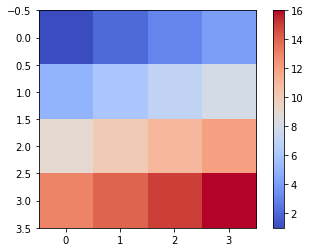

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# 定义数据
data = np.array([[1, 2, 3, 4], [5, 6, 7, 8], [9, 10, 11, 12], [13, 14, 15, 16]])

# 绘制热力图
plt.imshow(data, cmap='coolwarm', interpolation='nearest')
plt.colorbar()
plt.show()

In [5]:
nino_data2 = np.load(r'D:\heat_wave\atlantic\EINO_NINA_plot\Nino_data_with_MHW.npz')
nino_data2.files

['target_Nino_data_82_83',
 'target_Nino_data_87_88',
 'target_Nino_data_97_98',
 'target_Nino_data_02_03',
 'target_Nino_data_04_05',
 'target_Nino_data_09_10',
 'target_Nino_data_15_16',
 'target_Nino_data_18_19']

In [6]:
target_Nino_data_82_83 = nino_data2['target_Nino_data_82_83'][:]
target_Nino_data_87_88 = nino_data2['target_Nino_data_87_88'][:]
target_Nino_data_97_98 = nino_data2['target_Nino_data_97_98'][:]
target_Nino_data_02_03 = nino_data2['target_Nino_data_02_03'][:]
target_Nino_data_04_05 = nino_data2['target_Nino_data_04_05'][:]
target_Nino_data_09_10 = nino_data2['target_Nino_data_09_10'][:]
target_Nino_data_15_16 = nino_data2['target_Nino_data_15_16'][:]
target_Nino_data_18_19 = nino_data2['target_Nino_data_18_19'][:]

In [7]:
data_with_MHW_nino = np.mean([target_Nino_data_82_83, target_Nino_data_87_88,
                              target_Nino_data_97_98, target_Nino_data_02_03, 
                              target_Nino_data_04_05, target_Nino_data_09_10,
                              target_Nino_data_15_16,target_Nino_data_18_19], axis = 0)
data_with_MHW_nino.shape

(730, 82, 82)

In [8]:
data_with_MHW_nino = np.mean(data_with_MHW_nino, axis = 0)
data_with_MHW_nino.shape

(82, 82)

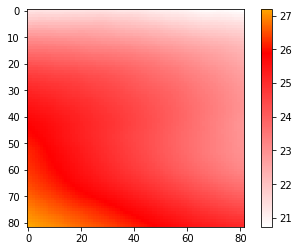

In [24]:
import matplotlib.colors as colors 
# cmap = colors.LinearSegmentedColormap.from_list('SST', [(0,'blue'), (0.5,'white'), (1,'red')])
# cmap = plt.cm.get_cmap('YlGn')
cmap = colors.LinearSegmentedColormap.from_list('SST', [(0,'white'), (0.8,'red'), (1,'orange')])

plt.imshow(data_with_MHW_nino, cmap=cmap, interpolation='nearest')
plt.colorbar()
plt.show()

In [6]:
t = np.arange(date(1982,1,1).toordinal(),date(2021,12,31).toordinal()+1)
dates = [date.fromordinal(tt.astype(int)) for tt in t]
# Generate synthetic temperature time series

data = np.load(r'D:\heat_wave\atlantic\SSTa_82_21_expand_atlantic_area.npz')['anom']
# print(data.shape) #(9861, 30, 41, 201)
# data = data[:,0,:,:]
print(np.min(data))

# sst = np.mean(data, axis=(1,2))

-5.6299996


In [27]:
mhws, clim = detect(t, sst)
clim['seas'].shape
data1 = clim['seas']
data1

array([24.67506796, 24.71304955, 24.75075857, ..., 24.55987124,
       24.59842202, 24.63684353])

In [30]:
mhws['n_events']

53

In [31]:
#春季

In [9]:
# n_event --- > 1
start_date = np.datetime64('1982-01-01')
dates = start_date + np.arange(14610) * np.timedelta64(1, 'D')

# 选择特定日期范围的数据
start_date_nino_spring_1 = np.datetime64('1983-11-18')
end_date_nino_spring_1 = np.datetime64('1983-11-28')
start_index_nino_spring_1 = np.where(dates == start_date_nino_spring_1)[0][0]
end_index_nino_spring_1 = np.where(dates == end_date_nino_spring_1)[0][0] + 1  # 注意要加 1，因为切片时 end_index 是开区间
target_data_nino_spring_1 = data[start_index_nino_spring_1:end_index_nino_spring_1]
target_data_nino_spring_1.shape

(11, 82, 82)

In [10]:
# n_event --- > 2
start_date = np.datetime64('1982-01-01')
dates = start_date + np.arange(14610) * np.timedelta64(1, 'D')

# 选择特定日期范围的数据
start_date_nino_spring_2 = np.datetime64('1983-12-15')
end_date_nino_spring_2 = np.datetime64('1983-12-19')
start_index_nino_spring_2 = np.where(dates == start_date_nino_spring_2)[0][0]
end_index_nino_spring_2 = np.where(dates == end_date_nino_spring_2)[0][0] + 1  # 注意要加 1，因为切片时 end_index 是开区间
target_data_nino_spring_2 = data[start_index_nino_spring_2:end_index_nino_spring_2]
target_data_nino_spring_2.shape

(5, 82, 82)

In [11]:
# n_event --- > 3
start_date = np.datetime64('1982-01-01')
dates = start_date + np.arange(14610) * np.timedelta64(1, 'D')

# 选择特定日期范围的数据
start_date_nino_spring_3 = np.datetime64('1987-10-05')
end_date_nino_spring_3 = np.datetime64('1987-11-12')
start_index_nino_spring_3 = np.where(dates == start_date_nino_spring_3)[0][0]
end_index_nino_spring_3 = np.where(dates == end_date_nino_spring_3)[0][0] + 1  # 注意要加 1，因为切片时 end_index 是开区间
target_data_nino_spring_3 = data[start_index_nino_spring_3:end_index_nino_spring_3]
target_data_nino_spring_3.shape

(39, 82, 82)

In [12]:
# n_event --- > 4
start_date = np.datetime64('1982-01-01')
dates = start_date + np.arange(14610) * np.timedelta64(1, 'D')

# 选择特定日期范围的数据
start_date_nino_spring_4 = np.datetime64('1987-11-21')
end_date_nino_spring_4 = np.datetime64('1987-12-16')
start_index_nino_spring_4 = np.where(dates == start_date_nino_spring_4)[0][0]
end_index_nino_spring_4 = np.where(dates == end_date_nino_spring_4)[0][0] + 1  # 注意要加 1，因为切片时 end_index 是开区间
target_data_nino_spring_4 = data[start_index_nino_spring_4:end_index_nino_spring_4]
target_data_nino_spring_4.shape

(26, 82, 82)

In [13]:
# n_event --- > 7
start_date = np.datetime64('1982-01-01')
dates = start_date + np.arange(14610) * np.timedelta64(1, 'D')

# 选择特定日期范围的数据
start_date_nino_spring_5 = np.datetime64('1989-10-09')
end_date_nino_spring_5 = np.datetime64('1989-10-14')
start_index_nino_spring_5 = np.where(dates == start_date_nino_spring_5)[0][0]
end_index_nino_spring_5 = np.where(dates == end_date_nino_spring_5)[0][0] + 1  # 注意要加 1，因为切片时 end_index 是开区间
target_data_nino_spring_5 = data[start_index_nino_spring_5 : end_index_nino_spring_5]
target_data_nino_spring_5.shape

(6, 82, 82)

In [14]:
# n_event --- > 9
start_date = np.datetime64('1982-01-01')
dates = start_date + np.arange(14610) * np.timedelta64(1, 'D')

# 选择特定日期范围的数据
start_date_nino_spring_6 = np.datetime64('1993-09-23')
end_date_nino_spring_6 = np.datetime64('1993-10-14')
start_index_nino_spring_6 = np.where(dates == start_date_nino_spring_6)[0][0]
end_index_nino_spring_6 = np.where(dates == end_date_nino_spring_6)[0][0] + 1  # 注意要加 1，因为切片时 end_index 是开区间
target_data_nino_spring_6 = data[start_index_nino_spring_6 : end_index_nino_spring_6]
target_data_nino_spring_6.shape

(22, 82, 82)

In [15]:
# n_event --- > 10
start_date = np.datetime64('1982-01-01')
dates = start_date + np.arange(14610) * np.timedelta64(1, 'D')

# 选择特定日期范围的数据
start_date_nino_spring_7 = np.datetime64('1993-11-19')
end_date_nino_spring_7 = np.datetime64('1993-11-25')
start_index_nino_spring_7 = np.where(dates == start_date_nino_spring_7)[0][0]
end_index_nino_spring_7 = np.where(dates == end_date_nino_spring_7)[0][0] + 1  # 注意要加 1，因为切片时 end_index 是开区间
target_data_nino_spring_7 = data[start_index_nino_spring_7 : end_index_nino_spring_7]
target_data_nino_spring_7.shape

(7, 82, 82)

In [16]:
# n_event --- > 12
start_date = np.datetime64('1982-01-01')
dates = start_date + np.arange(14610) * np.timedelta64(1, 'D')

# 选择特定日期范围的数据
start_date_nino_spring_8 = np.datetime64('1997-11-01')
end_date_nino_spring_8 = np.datetime64('1997-11-06')
start_index_nino_spring_8 = np.where(dates == start_date_nino_spring_8)[0][0]
end_index_nino_spring_8 = np.where(dates == end_date_nino_spring_8)[0][0] + 1  # 注意要加 1，因为切片时 end_index 是开区间
target_data_nino_spring_8 = data[start_index_nino_spring_8 : end_index_nino_spring_8]
target_data_nino_spring_8.shape

(6, 82, 82)

In [17]:
# n_event --- > 13
start_date = np.datetime64('1982-01-01')
dates = start_date + np.arange(14610) * np.timedelta64(1, 'D')

# 选择特定日期范围的数据
start_date_nino_spring_9 = np.datetime64('1998-02-25')
end_date_nino_spring_9 = np.datetime64('1998-03-04')
start_index_nino_spring_9 = np.where(dates == start_date_nino_spring_9)[0][0]
end_index_nino_spring_9 = np.where(dates == end_date_nino_spring_9)[0][0] + 1  # 注意要加 1，因为切片时 end_index 是开区间
target_data_nino_spring_9 = data[start_index_nino_spring_9 : end_index_nino_spring_9]
target_data_nino_spring_9.shape

(8, 82, 82)

In [18]:
# n_event --- > 17
start_date = np.datetime64('1982-01-01')
dates = start_date + np.arange(14610) * np.timedelta64(1, 'D')

# 选择特定日期范围的数据
start_date_nino_spring_10 = np.datetime64('2002-11-24')
end_date_nino_spring_10 = np.datetime64('2002-12-09')
start_index_nino_spring_10 = np.where(dates == start_date_nino_spring_10)[0][0]
end_index_nino_spring_10 = np.where(dates == end_date_nino_spring_10)[0][0] + 1  # 注意要加 1，因为切片时 end_index 是开区间
target_data_nino_spring_10 = data[start_index_nino_spring_10 : end_index_nino_spring_10]
target_data_nino_spring_10.shape

(16, 82, 82)

In [19]:
# n_event --- > 23
start_date = np.datetime64('1982-01-01')
dates = start_date + np.arange(14610) * np.timedelta64(1, 'D')

# 选择特定日期范围的数据
start_date_nino_spring_11 = np.datetime64('2003-10-13')
end_date_nino_spring_11 = np.datetime64('2003-11-06')
start_index_nino_spring_11 = np.where(dates == start_date_nino_spring_11)[0][0]
end_index_nino_spring_11 = np.where(dates == end_date_nino_spring_11)[0][0] + 1  # 注意要加 1，因为切片时 end_index 是开区间
target_data_nino_spring_11 = data[start_index_nino_spring_11 : end_index_nino_spring_11]
target_data_nino_spring_11.shape

(25, 82, 82)

In [20]:
# n_event --- > 23
start_date = np.datetime64('1982-01-01')
dates = start_date + np.arange(14610) * np.timedelta64(1, 'D')

# 选择特定日期范围的数据
start_date_nino_spring_12 = np.datetime64('2003-12-11')
end_date_nino_spring_12 = np.datetime64('2003-12-15')
start_index_nino_spring_12 = np.where(dates == start_date_nino_spring_12)[0][0]
end_index_nino_spring_12 = np.where(dates == end_date_nino_spring_12)[0][0] + 1  # 注意要加 1，因为切片时 end_index 是开区间
target_data_nino_spring_12 = data[start_index_nino_spring_12 : end_index_nino_spring_12]
target_data_nino_spring_12.shape

(5, 82, 82)

In [21]:
# n_event --- > 28
start_date = np.datetime64('1982-01-01')
dates = start_date + np.arange(14610) * np.timedelta64(1, 'D')

# 选择特定日期范围的数据
start_date_nino_spring_13 = np.datetime64('2009-09-23')
end_date_nino_spring_13 = np.datetime64('2009-12-12')
start_index_nino_spring_13 = np.where(dates == start_date_nino_spring_13)[0][0]
end_index_nino_spring_13 = np.where(dates == end_date_nino_spring_13)[0][0] + 1  # 注意要加 1，因为切片时 end_index 是开区间
target_data_nino_spring_13 = data[start_index_nino_spring_13 : end_index_nino_spring_13]
target_data_nino_spring_13.shape

(81, 82, 82)

In [22]:
# n_event --- > 36
start_date = np.datetime64('1982-01-01')
dates = start_date + np.arange(14610) * np.timedelta64(1, 'D')

# 选择特定日期范围的数据
start_date_nino_spring_14 = np.datetime64('2015-12-14')
end_date_nino_spring_14 = np.datetime64('2015-12-23')
start_index_nino_spring_14 = np.where(dates == start_date_nino_spring_14)[0][0]
end_index_nino_spring_14 = np.where(dates == end_date_nino_spring_14)[0][0] + 1  # 注意要加 1，因为切片时 end_index 是开区间
target_data_nino_spring_14 = data[start_index_nino_spring_14 : end_index_nino_spring_14]
target_data_nino_spring_14.shape

(10, 82, 82)

In [23]:
# n_event --- > 38
start_date = np.datetime64('1982-01-01')
dates = start_date + np.arange(14610) * np.timedelta64(1, 'D')

# 选择特定日期范围的数据
start_date_nino_spring_15 = np.datetime64('2016-09-23')
end_date_nino_spring_15 = np.datetime64('2016-10-03')
start_index_nino_spring_15 = np.where(dates == start_date_nino_spring_15)[0][0]
end_index_nino_spring_15 = np.where(dates == end_date_nino_spring_15)[0][0] + 1  # 注意要加 1，因为切片时 end_index 是开区间
target_data_nino_spring_15 = data[start_index_nino_spring_15 : end_index_nino_spring_15]
target_data_nino_spring_15.shape

(11, 82, 82)

In [24]:
# n_event --- > 39
start_date = np.datetime64('1982-01-01')
dates = start_date + np.arange(14610) * np.timedelta64(1, 'D')

# 选择特定日期范围的数据
start_date_nino_spring_16 = np.datetime64('2016-10-07')
end_date_nino_spring_16 = np.datetime64('2016-10-12')
start_index_nino_spring_16 = np.where(dates == start_date_nino_spring_16)[0][0]
end_index_nino_spring_16 = np.where(dates == end_date_nino_spring_16)[0][0] + 1  # 注意要加 1，因为切片时 end_index 是开区间
target_data_nino_spring_16 = data[start_index_nino_spring_16 : end_index_nino_spring_16]
target_data_nino_spring_16.shape

(6, 82, 82)

In [25]:
# n_event --- > 40
start_date = np.datetime64('1982-01-01')
dates = start_date + np.arange(14610) * np.timedelta64(1, 'D')

# 选择特定日期范围的数据
start_date_nino_spring_17 = np.datetime64('2016-12-09')
end_date_nino_spring_17 = np.datetime64('2016-12-15')
start_index_nino_spring_17 = np.where(dates == start_date_nino_spring_17)[0][0]
end_index_nino_spring_17 = np.where(dates == end_date_nino_spring_17)[0][0] + 1  # 注意要加 1，因为切片时 end_index 是开区间
target_data_nino_spring_17 = data[start_index_nino_spring_17 : end_index_nino_spring_17]
target_data_nino_spring_17.shape

(7, 82, 82)

In [26]:
# n_event --- > 48
start_date = np.datetime64('1982-01-01')
dates = start_date + np.arange(14610) * np.timedelta64(1, 'D')

# 选择特定日期范围的数据
start_date_nino_spring_18 = np.datetime64('2019-11-17')
end_date_nino_spring_18 = np.datetime64('2019-11-23')
start_index_nino_spring_18 = np.where(dates == start_date_nino_spring_18)[0][0]
end_index_nino_spring_18 = np.where(dates == end_date_nino_spring_18)[0][0] + 1  # 注意要加 1，因为切片时 end_index 是开区间
target_data_nino_spring_18 = data[start_index_nino_spring_18 : end_index_nino_spring_18]
target_data_nino_spring_18.shape

(7, 82, 82)

In [27]:
#夏季

In [28]:
# n_event --- > 5
start_date = np.datetime64('1982-01-01')
dates = start_date + np.arange(14610) * np.timedelta64(1, 'D')

# 选择特定日期范围的数据
start_date_nino_summer_1 = np.datetime64('1988-02-10')
end_date_nino_summer_1 = np.datetime64('1988-02-17')
start_index_nino_summer_1 = np.where(dates == start_date_nino_summer_1)[0][0]
end_index_nino_summer_1 = np.where(dates == end_date_nino_summer_1)[0][0] + 1  # 注意要加 1，因为切片时 end_index 是开区间
target_data_nino_summer_1 = data[start_index_nino_summer_1:end_index_nino_summer_1]
target_data_nino_summer_1.shape

(8, 82, 82)

In [29]:
# n_event --- > 18
start_date = np.datetime64('1982-01-01')
dates = start_date + np.arange(14610) * np.timedelta64(1, 'D')

# 选择特定日期范围的数据
start_date_nino_summer_2 = np.datetime64('2003-01-11')
end_date_nino_summer_2 = np.datetime64('2003-01-19')
start_index_nino_summer_2 = np.where(dates == start_date_nino_summer_2)[0][0]
end_index_nino_summer_2 = np.where(dates == end_date_nino_summer_2)[0][0] + 1  # 注意要加 1，因为切片时 end_index 是开区间
target_data_nino_summer_2 = data[start_index_nino_summer_2 : end_index_nino_summer_2]
target_data_nino_summer_2.shape

(9, 82, 82)

In [30]:
# n_event --- > 19
start_date = np.datetime64('1982-01-01')
dates = start_date + np.arange(14610) * np.timedelta64(1, 'D')

# 选择特定日期范围的数据
start_date_nino_summer_3 = np.datetime64('2003-02-02')
end_date_nino_summer_3 = np.datetime64('2003-03-16')
start_index_nino_summer_3 = np.where(dates == start_date_nino_summer_3)[0][0]
end_index_nino_summer_3 = np.where(dates == end_date_nino_summer_3)[0][0] + 1  # 注意要加 1，因为切片时 end_index 是开区间
target_data_nino_summer_3 = data[start_index_nino_summer_3 : end_index_nino_summer_3]
target_data_nino_summer_3.shape

(43, 82, 82)

In [31]:
# n_event --- > 28
start_date = np.datetime64('1982-01-01')
dates = start_date + np.arange(14610) * np.timedelta64(1, 'D')

# 选择特定日期范围的数据
start_date_nino_summer_4 = np.datetime64('2009-12-23')
end_date_nino_summer_4 = np.datetime64('2010-03-20')
start_index_nino_summer_4 = np.where(dates == start_date_nino_summer_4)[0][0]
end_index_nino_summer_4 = np.where(dates == end_date_nino_summer_4)[0][0] + 1  # 注意要加 1，因为切片时 end_index 是开区间
target_data_nino_summer_4 = data[start_index_nino_summer_4 : end_index_nino_summer_4]
target_data_nino_summer_4.shape

(88, 82, 82)

In [32]:
# n_event --- > 32
start_date = np.datetime64('1982-01-01')
dates = start_date + np.arange(14610) * np.timedelta64(1, 'D')

# 选择特定日期范围的数据
start_date_nino_summer_5 = np.datetime64('2014-02-04')
end_date_nino_summer_5 = np.datetime64('2014-02-21')
start_index_nino_summer_5 = np.where(dates == start_date_nino_summer_5)[0][0]
end_index_nino_summer_5 = np.where(dates == end_date_nino_summer_5)[0][0] + 1  # 注意要加 1，因为切片时 end_index 是开区间
target_data_nino_summer_5 = data[start_index_nino_summer_5 : end_index_nino_summer_5]
target_data_nino_summer_5.shape

(18, 82, 82)

In [33]:
# n_event --- > 32
start_date = np.datetime64('1982-01-01')
dates = start_date + np.arange(14610) * np.timedelta64(1, 'D')

# 选择特定日期范围的数据
start_date_nino_summer_6 = np.datetime64('2014-02-04')
end_date_nino_summer_6 = np.datetime64('2014-02-21')
start_index_nino_summer_6 = np.where(dates == start_date_nino_summer_6)[0][0]
end_index_nino_summer_6 = np.where(dates == end_date_nino_summer_6)[0][0] + 1  # 注意要加 1，因为切片时 end_index 是开区间
target_data_nino_summer_6 = data[start_index_nino_summer_6 : end_index_nino_summer_6]
target_data_nino_summer_6.shape

(18, 82, 82)

In [34]:
# n_event --- > 33
start_date = np.datetime64('1982-01-01')
dates = start_date + np.arange(14610) * np.timedelta64(1, 'D')

# 选择特定日期范围的数据
start_date_nino_summer_7 = np.datetime64('2014-03-04')
end_date_nino_summer_7 = np.datetime64('2014-03-13')
start_index_nino_summer_7 = np.where(dates == start_date_nino_summer_7)[0][0]
end_index_nino_summer_7 = np.where(dates == end_date_nino_summer_7)[0][0] + 1  # 注意要加 1，因为切片时 end_index 是开区间
target_data_nino_summer_7 = data[start_index_nino_summer_7 : end_index_nino_summer_7]
target_data_nino_summer_7.shape

(10, 82, 82)

In [35]:
# n_event --- > 34
start_date = np.datetime64('1982-01-01')
dates = start_date + np.arange(14610) * np.timedelta64(1, 'D')

# 选择特定日期范围的数据
start_date_nino_summer_8 = np.datetime64('2015-01-12')
end_date_nino_summer_8 = np.datetime64('2015-02-17')
start_index_nino_summer_8 = np.where(dates == start_date_nino_summer_8)[0][0]
end_index_nino_summer_8 = np.where(dates == end_date_nino_summer_8)[0][0] + 1  # 注意要加 1，因为切片时 end_index 是开区间
target_data_nino_summer_8 = data[start_index_nino_summer_8 : end_index_nino_summer_8]
target_data_nino_summer_8.shape

(37, 82, 82)

In [36]:
# n_event --- > 37
start_date = np.datetime64('1982-01-01')
dates = start_date + np.arange(14610) * np.timedelta64(1, 'D')

# 选择特定日期范围的数据
start_date_nino_summer_9= np.datetime64('2016-02-29')
end_date_nino_summer_9 = np.datetime64('2016-03-05')
start_index_nino_summer_9 = np.where(dates == start_date_nino_summer_9)[0][0]
end_index_nino_summer_9 = np.where(dates == end_date_nino_summer_9)[0][0] + 1  # 注意要加 1，因为切片时 end_index 是开区间
target_data_nino_summer_9 = data[start_index_nino_summer_9 : end_index_nino_summer_9]
target_data_nino_summer_9.shape

(6, 82, 82)

In [37]:
# n_event --- > 41
start_date = np.datetime64('1982-01-01')
dates = start_date + np.arange(14610) * np.timedelta64(1, 'D')

# 选择特定日期范围的数据
start_date_nino_summer_10= np.datetime64('2017-01-07')
end_date_nino_summer_10 = np.datetime64('2017-01-26')
start_index_nino_summer_10 = np.where(dates == start_date_nino_summer_10)[0][0]
end_index_nino_summer_10 = np.where(dates == end_date_nino_summer_10)[0][0] + 1  # 注意要加 1，因为切片时 end_index 是开区间
target_data_nino_summer_10 = data[start_index_nino_summer_10 : end_index_nino_summer_10]
target_data_nino_summer_10.shape

(20, 82, 82)

In [38]:
# n_event --- > 42
start_date = np.datetime64('1982-01-01')
dates = start_date + np.arange(14610) * np.timedelta64(1, 'D')

# 选择特定日期范围的数据
start_date_nino_summer_11= np.datetime64('2019-01-13')
end_date_nino_summer_11 = np.datetime64('2019-02-04')
start_index_nino_summer_11 = np.where(dates == start_date_nino_summer_11)[0][0]
end_index_nino_summer_11 = np.where(dates == end_date_nino_summer_11)[0][0] + 1  # 注意要加 1，因为切片时 end_index 是开区间
target_data_nino_summer_11 = data[start_index_nino_summer_11 : end_index_nino_summer_11]
target_data_nino_summer_11.shape

(23, 82, 82)

In [39]:
# n_event --- > 43
start_date = np.datetime64('1982-01-01')
dates = start_date + np.arange(14610) * np.timedelta64(1, 'D')

# 选择特定日期范围的数据
start_date_nino_summer_12= np.datetime64('2019-02-15')
end_date_nino_summer_12 = np.datetime64('2019-03-20')
start_index_nino_summer_12 = np.where(dates == start_date_nino_summer_12)[0][0]
end_index_nino_summer_12 = np.where(dates == end_date_nino_summer_12)[0][0] + 1  # 注意要加 1，因为切片时 end_index 是开区间
target_data_nino_summer_12 = data[start_index_nino_summer_12 : end_index_nino_summer_12]
target_data_nino_summer_12.shape

(34, 82, 82)

In [40]:
# n_event --- > 49
start_date = np.datetime64('1982-01-01')
dates = start_date + np.arange(14610) * np.timedelta64(1, 'D')

# 选择特定日期范围的数据
start_date_nino_summer_13= np.datetime64('2020-01-09')
end_date_nino_summer_13 = np.datetime64('2020-01-25')
start_index_nino_summer_13 = np.where(dates == start_date_nino_summer_13)[0][0]
end_index_nino_summer_13 = np.where(dates == end_date_nino_summer_13)[0][0] + 1  # 注意要加 1，因为切片时 end_index 是开区间
target_data_nino_summer_13 = data[start_index_nino_summer_13 : end_index_nino_summer_13]
target_data_nino_summer_13.shape

(17, 82, 82)

In [41]:
# n_event --- > 50
start_date = np.datetime64('1982-01-01')
dates = start_date + np.arange(14610) * np.timedelta64(1, 'D')

# 选择特定日期范围的数据
start_date_nino_summer_14= np.datetime64('2020-03-15')
end_date_nino_summer_14 = np.datetime64('2020-03-20')
start_index_nino_summer_14 = np.where(dates == start_date_nino_summer_14)[0][0]
end_index_nino_summer_14 = np.where(dates == end_date_nino_summer_14)[0][0] + 1  # 注意要加 1，因为切片时 end_index 是开区间
target_data_nino_summer_14 = data[start_index_nino_summer_14 : end_index_nino_summer_14]
target_data_nino_summer_14.shape

(6, 82, 82)

In [42]:
#秋季

In [43]:
# n_event --- > 6
start_date = np.datetime64('1982-01-01')
dates = start_date + np.arange(14610) * np.timedelta64(1, 'D')

# 选择特定日期范围的数据
start_date_nino_autumn_1 = np.datetime64('1988-03-26')
end_date_nino_autumn_1 = np.datetime64('1988-04-07')
start_index_nino_autumn_1 = np.where(dates == start_date_nino_autumn_1)[0][0]
end_index_nino_autumn_1 = np.where(dates == end_date_nino_autumn_1)[0][0] + 1  # 注意要加 1，因为切片时 end_index 是开区间
target_data_nino_autumn_1 = data[start_index_nino_autumn_1:end_index_nino_autumn_1]
target_data_nino_autumn_1.shape

(13, 82, 82)

In [44]:
# n_event --- > 11
start_date = np.datetime64('1982-01-01')
dates = start_date + np.arange(14610) * np.timedelta64(1, 'D')

# 选择特定日期范围的数据
start_date_nino_autumn_2 = np.datetime64('1995-04-24')
end_date_nino_autumn_2 = np.datetime64('1995-05-03')
start_index_nino_autumn_2 = np.where(dates == start_date_nino_autumn_2)[0][0]
end_index_nino_autumn_2 = np.where(dates == end_date_nino_autumn_2)[0][0] + 1  # 注意要加 1，因为切片时 end_index 是开区间
target_data_nino_autumn_2 = data[start_index_nino_autumn_2:end_index_nino_autumn_2]
target_data_nino_autumn_2.shape

(10, 82, 82)

In [45]:
# n_event --- > 20
start_date = np.datetime64('1982-01-01')
dates = start_date + np.arange(14610) * np.timedelta64(1, 'D')

# 选择特定日期范围的数据
start_date_nino_autumn_3 = np.datetime64('2003-04-07')
end_date_nino_autumn_3 = np.datetime64('2003-05-10')
start_index_nino_autumn_3 = np.where(dates == start_date_nino_autumn_3)[0][0]
end_index_nino_autumn_3 = np.where(dates == end_date_nino_autumn_3)[0][0] + 1  # 注意要加 1，因为切片时 end_index 是开区间
target_data_nino_autumn_3 = data[start_index_nino_autumn_3:end_index_nino_autumn_3]
target_data_nino_autumn_3.shape

(34, 82, 82)

In [46]:
# n_event --- > 20
start_date = np.datetime64('1982-01-01')
dates = start_date + np.arange(14610) * np.timedelta64(1, 'D')

# 选择特定日期范围的数据
start_date_nino_autumn_4 = np.datetime64('2003-05-28')
end_date_nino_autumn_4 = np.datetime64('2003-06-22')
start_index_nino_autumn_4 = np.where(dates == start_date_nino_autumn_4)[0][0]
end_index_nino_autumn_4 = np.where(dates == end_date_nino_autumn_4)[0][0] + 1  # 注意要加 1，因为切片时 end_index 是开区间
target_data_nino_autumn_4 = data[start_index_nino_autumn_4 : end_index_nino_autumn_4]
target_data_nino_autumn_4.shape

(26, 82, 82)

In [47]:
# n_event --- > 20
start_date = np.datetime64('1982-01-01')
dates = start_date + np.arange(14610) * np.timedelta64(1, 'D')

# 选择特定日期范围的数据
start_date_nino_autumn_5 = np.datetime64('2008-04-22')
end_date_nino_autumn_5 = np.datetime64('2008-04-30')
start_index_nino_autumn_5 = np.where(dates == start_date_nino_autumn_5)[0][0]
end_index_nino_autumn_5 = np.where(dates == end_date_nino_autumn_5)[0][0] + 1  # 注意要加 1，因为切片时 end_index 是开区间
target_data_nino_autumn_5 = data[start_index_nino_autumn_5 : end_index_nino_autumn_5]
target_data_nino_autumn_5.shape

(9, 82, 82)

In [48]:
# n_event --- > 20
start_date = np.datetime64('1982-01-01')
dates = start_date + np.arange(14610) * np.timedelta64(1, 'D')

# 选择特定日期范围的数据
start_date_nino_autumn_6 = np.datetime64('2008-04-22')
end_date_nino_autumn_6 = np.datetime64('2008-04-30')
start_index_nino_autumn_6 = np.where(dates == start_date_nino_autumn_6)[0][0]
end_index_nino_autumn_6 = np.where(dates == end_date_nino_autumn_6)[0][0] + 1  # 注意要加 1，因为切片时 end_index 是开区间
target_data_nino_autumn_6 = data[start_index_nino_autumn_6 : end_index_nino_autumn_6]
target_data_nino_autumn_6.shape

(9, 82, 82)

In [49]:
# n_event --- > 28
start_date = np.datetime64('1982-01-01')
dates = start_date + np.arange(14610) * np.timedelta64(1, 'D')

# 选择特定日期范围的数据
start_date_nino_autumn_7 = np.datetime64('2010-03-21')
end_date_nino_autumn_7 = np.datetime64('2010-04-18')
start_index_nino_autumn_7 = np.where(dates == start_date_nino_autumn_7)[0][0]
end_index_nino_autumn_7 = np.where(dates == end_date_nino_autumn_7)[0][0] + 1  # 注意要加 1，因为切片时 end_index 是开区间
target_data_nino_autumn_7 = data[start_index_nino_autumn_7 : end_index_nino_autumn_7]
target_data_nino_autumn_7.shape

(29, 82, 82)

In [50]:
# n_event --- > 29
start_date = np.datetime64('1982-01-01')
dates = start_date + np.arange(14610) * np.timedelta64(1, 'D')

# 选择特定日期范围的数据
start_date_nino_autumn_8 = np.datetime64('2010-05-06')
end_date_nino_autumn_8 = np.datetime64('2010-06-22')
start_index_nino_autumn_8 = np.where(dates == start_date_nino_autumn_8)[0][0]
end_index_nino_autumn_8 = np.where(dates == end_date_nino_autumn_8)[0][0] + 1  # 注意要加 1，因为切片时 end_index 是开区间
target_data_nino_autumn_8 = data[start_index_nino_autumn_8 : end_index_nino_autumn_8]
target_data_nino_autumn_8.shape

(48, 82, 82)

In [51]:
# n_event --- > 35
start_date = np.datetime64('1982-01-01')
dates = start_date + np.arange(14610) * np.timedelta64(1, 'D')

# 选择特定日期范围的数据
start_date_nino_autumn_9 = np.datetime64('2015-03-24')
end_date_nino_autumn_9 = np.datetime64('2015-03-31')
start_index_nino_autumn_9 = np.where(dates == start_date_nino_autumn_9)[0][0]
end_index_nino_autumn_9 = np.where(dates == end_date_nino_autumn_9)[0][0] + 1  # 注意要加 1，因为切片时 end_index 是开区间
target_data_nino_autumn_9 = data[start_index_nino_autumn_9 : end_index_nino_autumn_9]
target_data_nino_autumn_9.shape

(8, 82, 82)

In [52]:
# n_event --- > 38
start_date = np.datetime64('1982-01-01')
dates = start_date + np.arange(14610) * np.timedelta64(1, 'D')

# 选择特定日期范围的数据
start_date_nino_autumn_10 = np.datetime64('2016-06-11')
end_date_nino_autumn_10 = np.datetime64('2016-06-22')
start_index_nino_autumn_10 = np.where(dates == start_date_nino_autumn_10)[0][0]
end_index_nino_autumn_10 = np.where(dates == end_date_nino_autumn_10)[0][0] + 1  # 注意要加 1，因为切片时 end_index 是开区间
target_data_nino_autumn_10 = data[start_index_nino_autumn_10 : end_index_nino_autumn_10]
target_data_nino_autumn_10.shape

(12, 82, 82)

In [53]:
# n_event --- > 43
start_date = np.datetime64('1982-01-01')
dates = start_date + np.arange(14610) * np.timedelta64(1, 'D')

# 选择特定日期范围的数据
start_date_nino_autumn_11 = np.datetime64('2019-03-21')
end_date_nino_autumn_11 = np.datetime64('2019-06-22')
start_index_nino_autumn_11 = np.where(dates == start_date_nino_autumn_11)[0][0]
end_index_nino_autumn_11 = np.where(dates == end_date_nino_autumn_11)[0][0] + 1  # 注意要加 1，因为切片时 end_index 是开区间
target_data_nino_autumn_11 = data[start_index_nino_autumn_11 : end_index_nino_autumn_11]
target_data_nino_autumn_11.shape

(94, 82, 82)

In [54]:
# n_event --- > 50
start_date = np.datetime64('1982-01-01')
dates = start_date + np.arange(14610) * np.timedelta64(1, 'D')

# 选择特定日期范围的数据
start_date_nino_autumn_12 = np.datetime64('2020-03-21')
end_date_nino_autumn_12 = np.datetime64('2020-05-20')
start_index_nino_autumn_12 = np.where(dates == start_date_nino_autumn_12)[0][0]
end_index_nino_autumn_12 = np.where(dates == end_date_nino_autumn_12)[0][0] + 1  # 注意要加 1，因为切片时 end_index 是开区间
target_data_nino_autumn_12 = data[start_index_nino_autumn_12 : end_index_nino_autumn_12]
target_data_nino_autumn_12.shape

(61, 82, 82)

In [55]:
# n_event --- > 51
start_date = np.datetime64('1982-01-01')
dates = start_date + np.arange(14610) * np.timedelta64(1, 'D')

# 选择特定日期范围的数据
start_date_nino_autumn_13 = np.datetime64('2020-06-02')
end_date_nino_autumn_13 = np.datetime64('2020-06-07')
start_index_nino_autumn_13 = np.where(dates == start_date_nino_autumn_13)[0][0]
end_index_nino_autumn_13 = np.where(dates == end_date_nino_autumn_13)[0][0] + 1  # 注意要加 1，因为切片时 end_index 是开区间
target_data_nino_autumn_13 = data[start_index_nino_autumn_13 : end_index_nino_autumn_13]
target_data_nino_autumn_13.shape

(6, 82, 82)

In [56]:
# n_event --- > 53
start_date = np.datetime64('1982-01-01')
dates = start_date + np.arange(14610) * np.timedelta64(1, 'D')

# 选择特定日期范围的数据
start_date_nino_autumn_14 = np.datetime64('2021-05-20')
end_date_nino_autumn_14 = np.datetime64('2021-06-03')
start_index_nino_autumn_14 = np.where(dates == start_date_nino_autumn_14)[0][0]
end_index_nino_autumn_14 = np.where(dates == end_date_nino_autumn_14)[0][0] + 1  # 注意要加 1，因为切片时 end_index 是开区间
target_data_nino_autumn_14 = data[start_index_nino_autumn_14 : end_index_nino_autumn_14]
target_data_nino_autumn_14.shape

(15, 82, 82)

In [57]:
#冬季

In [58]:
# n_event --- > 8
start_date = np.datetime64('1982-01-01')
dates = start_date + np.arange(14610) * np.timedelta64(1, 'D')

# 选择特定日期范围的数据
start_date_nino_winter_1 = np.datetime64('1993-09-05')
end_date_nino_winter_1 = np.datetime64('1993-09-12')
start_index_nino_winter_1 = np.where(dates == start_date_nino_winter_1)[0][0]
end_index_nino_winter_1 = np.where(dates == end_date_nino_winter_1)[0][0] + 1  # 注意要加 1，因为切片时 end_index 是开区间
target_data_nino_winter_1 = data[start_index_nino_winter_1:end_index_nino_winter_1]
target_data_nino_winter_1.shape

(8, 82, 82)

In [59]:
# n_event --- > 8
start_date = np.datetime64('1982-01-01')
dates = start_date + np.arange(14610) * np.timedelta64(1, 'D')

# 选择特定日期范围的数据
start_date_nino_winter_2 = np.datetime64('1993-09-18')
end_date_nino_winter_2 = np.datetime64('1993-09-22')
start_index_nino_winter_2 = np.where(dates == start_date_nino_winter_2)[0][0]
end_index_nino_winter_2 = np.where(dates == end_date_nino_winter_2)[0][0] + 1  # 注意要加 1，因为切片时 end_index 是开区间
target_data_nino_winter_2 = data[start_index_nino_winter_2:end_index_nino_winter_2]
target_data_nino_winter_2.shape

(5, 82, 82)

In [60]:
# n_event --- > 14
start_date = np.datetime64('1982-01-01')
dates = start_date + np.arange(14610) * np.timedelta64(1, 'D')

# 选择特定日期范围的数据
start_date_nino_winter_3 = np.datetime64('1998-07-10')
end_date_nino_winter_3 = np.datetime64('1998-07-25')
start_index_nino_winter_3 = np.where(dates == start_date_nino_winter_3)[0][0]
end_index_nino_winter_3 = np.where(dates == end_date_nino_winter_3)[0][0] + 1  # 注意要加 1，因为切片时 end_index 是开区间
target_data_nino_winter_3 = data[start_index_nino_winter_3:end_index_nino_winter_3]
target_data_nino_winter_3.shape

(16, 82, 82)

In [61]:
# n_event --- > 15
start_date = np.datetime64('1982-01-01')
dates = start_date + np.arange(14610) * np.timedelta64(1, 'D')

# 选择特定日期范围的数据
start_date_nino_winter_4 = np.datetime64('2002-07-11')
end_date_nino_winter_4 = np.datetime64('2002-07-16')
start_index_nino_winter_4 = np.where(dates == start_date_nino_winter_4)[0][0]
end_index_nino_winter_4 = np.where(dates == end_date_nino_winter_4)[0][0] + 1  # 注意要加 1，因为切片时 end_index 是开区间
target_data_nino_winter_4 = data[start_index_nino_winter_4:end_index_nino_winter_4]
target_data_nino_winter_4.shape

(6, 82, 82)

In [62]:
# n_event --- > 16
start_date = np.datetime64('1982-01-01')
dates = start_date + np.arange(14610) * np.timedelta64(1, 'D')

# 选择特定日期范围的数据
start_date_nino_winter_5 = np.datetime64('2002-09-05')
end_date_nino_winter_5 = np.datetime64('2002-09-13')
start_index_nino_winter_5 = np.where(dates == start_date_nino_winter_5)[0][0]
end_index_nino_winter_5 = np.where(dates == end_date_nino_winter_5)[0][0] + 1  # 注意要加 1，因为切片时 end_index 是开区间
target_data_nino_winter_5 = data[start_index_nino_winter_5 : end_index_nino_winter_5]
target_data_nino_winter_5.shape

(9, 82, 82)

In [63]:
# n_event --- > 21
start_date = np.datetime64('1982-01-01')
dates = start_date + np.arange(14610) * np.timedelta64(1, 'D')

# 选择特定日期范围的数据
start_date_nino_winter_6 = np.datetime64('2003-06-23')
end_date_nino_winter_6 = np.datetime64('2003-06-24')
start_index_nino_winter_6 = np.where(dates == start_date_nino_winter_6)[0][0]
end_index_nino_winter_6 = np.where(dates == end_date_nino_winter_6)[0][0] + 1  # 注意要加 1，因为切片时 end_index 是开区间
target_data_nino_winter_6 = data[start_index_nino_winter_6 : end_index_nino_winter_6]
target_data_nino_winter_6.shape

(2, 82, 82)

In [64]:
# n_event --- > 22
start_date = np.datetime64('1982-01-01')
dates = start_date + np.arange(14610) * np.timedelta64(1, 'D')

# 选择特定日期范围的数据
start_date_nino_winter_7 = np.datetime64('2003-08-06')
end_date_nino_winter_7 = np.datetime64('2003-09-01')
start_index_nino_winter_7 = np.where(dates == start_date_nino_winter_7)[0][0]
end_index_nino_winter_7 = np.where(dates == end_date_nino_winter_7)[0][0] + 1  # 注意要加 1，因为切片时 end_index 是开区间
target_data_nino_winter_7 = data[start_index_nino_winter_7 : end_index_nino_winter_7]
target_data_nino_winter_7.shape

(27, 82, 82)

In [65]:
# n_event --- > 25
start_date = np.datetime64('1982-01-01')
dates = start_date + np.arange(14610) * np.timedelta64(1, 'D')

# 选择特定日期范围的数据
start_date_nino_winter_8 = np.datetime64('2004-07-28')
end_date_nino_winter_8 = np.datetime64('2004-08-04')
start_index_nino_winter_8 = np.where(dates == start_date_nino_winter_8)[0][0]
end_index_nino_winter_8 = np.where(dates == end_date_nino_winter_8)[0][0] + 1  # 注意要加 1，因为切片时 end_index 是开区间
target_data_nino_winter_8 = data[start_index_nino_winter_8 : end_index_nino_winter_8]
target_data_nino_winter_8.shape

(8, 82, 82)

In [66]:
# n_event --- > 26
start_date = np.datetime64('1982-01-01')
dates = start_date + np.arange(14610) * np.timedelta64(1, 'D')

# 选择特定日期范围的数据
start_date_nino_winter_9 = np.datetime64('2004-08-24')
end_date_nino_winter_9 = np.datetime64('2004-09-02')
start_index_nino_winter_9 = np.where(dates == start_date_nino_winter_9)[0][0]
end_index_nino_winter_9 = np.where(dates == end_date_nino_winter_9)[0][0] + 1  # 注意要加 1，因为切片时 end_index 是开区间
target_data_nino_winter_9 = data[start_index_nino_winter_9 : end_index_nino_winter_9]
target_data_nino_winter_9.shape

(10, 82, 82)

In [67]:
# n_event --- > 28
start_date = np.datetime64('1982-01-01')
dates = start_date + np.arange(14610) * np.timedelta64(1, 'D')

# 选择特定日期范围的数据
start_date_nino_winter_10 = np.datetime64('2009-09-20')
end_date_nino_winter_10 = np.datetime64('2009-09-22')
start_index_nino_winter_10 = np.where(dates == start_date_nino_winter_10)[0][0]
end_index_nino_winter_10 = np.where(dates == end_date_nino_winter_10)[0][0] + 1  # 注意要加 1，因为切片时 end_index 是开区间
target_data_nino_winter_10 = data[start_index_nino_winter_10 : end_index_nino_winter_10]
target_data_nino_winter_10.shape

(3, 82, 82)

In [68]:
# n_event --- > 29
start_date = np.datetime64('1982-01-01')
dates = start_date + np.arange(14610) * np.timedelta64(1, 'D')

# 选择特定日期范围的数据
start_date_nino_winter_11 = np.datetime64('2010-06-23')
end_date_nino_winter_11 = np.datetime64('2010-06-28')
start_index_nino_winter_11 = np.where(dates == start_date_nino_winter_11)[0][0]
end_index_nino_winter_11 = np.where(dates == end_date_nino_winter_11)[0][0] + 1  # 注意要加 1，因为切片时 end_index 是开区间
target_data_nino_winter_11 = data[start_index_nino_winter_11 : end_index_nino_winter_11]
target_data_nino_winter_11.shape

(6, 82, 82)

In [69]:
# n_event --- > 30
start_date = np.datetime64('1982-01-01')
dates = start_date + np.arange(14610) * np.timedelta64(1, 'D')

# 选择特定日期范围的数据
start_date_nino_winter_12 = np.datetime64('2013-08-05')
end_date_nino_winter_12 = np.datetime64('2013-08-13')
start_index_nino_winter_12 = np.where(dates == start_date_nino_winter_12)[0][0]
end_index_nino_winter_12 = np.where(dates == end_date_nino_winter_12)[0][0] + 1  # 注意要加 1，因为切片时 end_index 是开区间
target_data_nino_winter_12 = data[start_index_nino_winter_12 : end_index_nino_winter_12]
target_data_nino_winter_12.shape

(9, 82, 82)

In [70]:
# n_event --- > 31
start_date = np.datetime64('1982-01-01')
dates = start_date + np.arange(14610) * np.timedelta64(1, 'D')

# 选择特定日期范围的数据
start_date_nino_winter_13 = np.datetime64('2013-08-29')
end_date_nino_winter_13 = np.datetime64('2013-09-03')
start_index_nino_winter_13 = np.where(dates == start_date_nino_winter_13)[0][0]
end_index_nino_winter_13 = np.where(dates == end_date_nino_winter_13)[0][0] + 1  # 注意要加 1，因为切片时 end_index 是开区间
target_data_nino_winter_13 = data[start_index_nino_winter_13 : end_index_nino_winter_13]
target_data_nino_winter_13.shape

(6, 82, 82)

In [71]:
# n_event --- > 38
start_date = np.datetime64('1982-01-01')
dates = start_date + np.arange(14610) * np.timedelta64(1, 'D')

# 选择特定日期范围的数据
start_date_nino_winter_14 = np.datetime64('2016-06-23')
end_date_nino_winter_14 = np.datetime64('2016-09-22')
start_index_nino_winter_14 = np.where(dates == start_date_nino_winter_14)[0][0]
end_index_nino_winter_14 = np.where(dates == end_date_nino_winter_14)[0][0] + 1  # 注意要加 1，因为切片时 end_index 是开区间
target_data_nino_winter_14 = data[start_index_nino_winter_14 : end_index_nino_winter_14]
target_data_nino_winter_14.shape

(92, 82, 82)

In [72]:
# n_event --- > 43
start_date = np.datetime64('1982-01-01')
dates = start_date + np.arange(14610) * np.timedelta64(1, 'D')

# 选择特定日期范围的数据
start_date_nino_winter_15 = np.datetime64('2019-06-23')
end_date_nino_winter_15 = np.datetime64('2019-06-28')
start_index_nino_winter_15 = np.where(dates == start_date_nino_winter_15)[0][0]
end_index_nino_winter_15 = np.where(dates == end_date_nino_winter_15)[0][0] + 1  # 注意要加 1，因为切片时 end_index 是开区间
target_data_nino_winter_15 = data[start_index_nino_winter_15 : end_index_nino_winter_15]
target_data_nino_winter_15.shape

(6, 82, 82)

In [73]:
# n_event --- > 44
start_date = np.datetime64('1982-01-01')
dates = start_date + np.arange(14610) * np.timedelta64(1, 'D')

# 选择特定日期范围的数据
start_date_nino_winter_16 = np.datetime64('2019-07-11')
end_date_nino_winter_16 = np.datetime64('2019-07-20')
start_index_nino_winter_16 = np.where(dates == start_date_nino_winter_16)[0][0]
end_index_nino_winter_16 = np.where(dates == end_date_nino_winter_16)[0][0] + 1  # 注意要加 1，因为切片时 end_index 是开区间
target_data_nino_winter_16 = data[start_index_nino_winter_16 : end_index_nino_winter_16]
target_data_nino_winter_16.shape

(10, 82, 82)

In [74]:
# n_event --- > 45
start_date = np.datetime64('1982-01-01')
dates = start_date + np.arange(14610) * np.timedelta64(1, 'D')

# 选择特定日期范围的数据
start_date_nino_winter_17 = np.datetime64('2019-07-24')
end_date_nino_winter_17 = np.datetime64('2019-07-28')
start_index_nino_winter_17 = np.where(dates == start_date_nino_winter_17)[0][0]
end_index_nino_winter_17 = np.where(dates == end_date_nino_winter_17)[0][0] + 1  # 注意要加 1，因为切片时 end_index 是开区间
target_data_nino_winter_17 = data[start_index_nino_winter_17 : end_index_nino_winter_17]
target_data_nino_winter_17.shape

(5, 82, 82)

In [75]:
# n_event --- > 46
start_date = np.datetime64('1982-01-01')
dates = start_date + np.arange(14610) * np.timedelta64(1, 'D')

# 选择特定日期范围的数据
start_date_nino_winter_18 = np.datetime64('2019-08-01')
end_date_nino_winter_18 = np.datetime64('2019-08-08')
start_index_nino_winter_18 = np.where(dates == start_date_nino_winter_18)[0][0]
end_index_nino_winter_18 = np.where(dates == end_date_nino_winter_18)[0][0] + 1  # 注意要加 1，因为切片时 end_index 是开区间
target_data_nino_winter_18 = data[start_index_nino_winter_18 : end_index_nino_winter_18]
target_data_nino_winter_18.shape

(8, 82, 82)

In [76]:
# n_event --- > 47
start_date = np.datetime64('1982-01-01')
dates = start_date + np.arange(14610) * np.timedelta64(1, 'D')

# 选择特定日期范围的数据
start_date_nino_winter_19 = np.datetime64('2019-09-12')
end_date_nino_winter_19 = np.datetime64('2019-09-16')
start_index_nino_winter_19 = np.where(dates == start_date_nino_winter_19)[0][0]
end_index_nino_winter_19 = np.where(dates == end_date_nino_winter_19)[0][0] + 1  # 注意要加 1，因为切片时 end_index 是开区间
target_data_nino_winter_19 = data[start_index_nino_winter_19 : end_index_nino_winter_19]
target_data_nino_winter_19.shape

(5, 82, 82)

In [77]:
# n_event --- > 52
start_date = np.datetime64('1982-01-01')
dates = start_date + np.arange(14610) * np.timedelta64(1, 'D')

# 选择特定日期范围的数据
start_date_nino_winter_20 = np.datetime64('2020-08-03')
end_date_nino_winter_20 = np.datetime64('2020-08-10')
start_index_nino_winter_20 = np.where(dates == start_date_nino_winter_20)[0][0]
end_index_nino_winter_20 = np.where(dates == end_date_nino_winter_20)[0][0] + 1  # 注意要加 1，因为切片时 end_index 是开区间
target_data_nino_winter_20 = data[start_index_nino_winter_20 : end_index_nino_winter_20]
target_data_nino_winter_20.shape

(8, 82, 82)

In [78]:
#春季 18个event

In [82]:
np.savez(r'D:\heat_wave\atlantic\Nino_spring_summer_autumn_winter_imshow\heat_wave_spring_ssta.npz',
        target_data_nino_spring_1 = target_data_nino_spring_1, target_data_nino_spring_2 = target_data_nino_spring_2,
        target_data_nino_spring_3 = target_data_nino_spring_3, target_data_nino_spring_4 = target_data_nino_spring_4,
        target_data_nino_spring_5 = target_data_nino_spring_5, target_data_nino_spring_6 = target_data_nino_spring_6,
        target_data_nino_spring_7 = target_data_nino_spring_7, target_data_nino_spring_8 = target_data_nino_spring_8,
        target_data_nino_spring_9 = target_data_nino_spring_9, target_data_nino_spring_10 = target_data_nino_spring_10,
        target_data_nino_spring_11 = target_data_nino_spring_11, target_data_nino_spring_12 = target_data_nino_spring_12,
        target_data_nino_spring_13 = target_data_nino_spring_13, target_data_nino_spring_14 = target_data_nino_spring_14,
        target_data_nino_spring_15 = target_data_nino_spring_15, target_data_nino_spring_16 = target_data_nino_spring_16,
        target_data_nino_spring_17 = target_data_nino_spring_17, target_data_nino_spring_18 = target_data_nino_spring_18)

In [80]:
#夏季 14个 event

In [83]:
np.savez(r'D:\heat_wave\atlantic\Nino_spring_summer_autumn_winter_imshow\heat_wave_summer_ssta.npz',
        target_data_nino_summer_1 = target_data_nino_summer_1, target_data_nino_summer_2 = target_data_nino_summer_2,
        target_data_nino_summer_3 = target_data_nino_summer_3, target_data_nino_summer_4 = target_data_nino_summer_4,
        target_data_nino_summer_5 = target_data_nino_summer_5, target_data_nino_summer_6 = target_data_nino_summer_6,
        target_data_nino_summer_7 = target_data_nino_summer_7, target_data_nino_summer_8 = target_data_nino_summer_8,
        target_data_nino_summer_9 = target_data_nino_summer_9, target_data_nino_summer_10 = target_data_nino_summer_10,
        target_data_nino_summer_11 = target_data_nino_summer_11, target_data_nino_summer_12 = target_data_nino_summer_12,
        target_data_nino_summer_13 = target_data_nino_summer_13, target_data_nino_summer_14 = target_data_nino_summer_14)

In [137]:
#秋季 14个 event

In [84]:
np.savez(r'D:\heat_wave\atlantic\Nino_spring_summer_autumn_winter_imshow\heat_wave_autumn_ssta.npz',
       target_data_nino_autumn_1 = target_data_nino_autumn_1, target_data_nino_autumn_2 = target_data_nino_autumn_2,
        target_data_nino_autumn_3 = target_data_nino_autumn_3, target_data_nino_autumn_4 = target_data_nino_autumn_4,
        target_data_nino_autumn_5 = target_data_nino_autumn_5, target_data_nino_autumn_6 = target_data_nino_autumn_6,
        target_data_nino_autumn_7 = target_data_nino_autumn_7, target_data_nino_autumn_8 = target_data_nino_autumn_8,
        target_data_nino_autumn_9 = target_data_nino_autumn_9, target_data_nino_autumn_10 = target_data_nino_autumn_10,
        target_data_nino_autumn_11 = target_data_nino_autumn_11, target_data_nino_autumn_12 = target_data_nino_autumn_12,
        target_data_nino_autumn_13 = target_data_nino_autumn_13, target_data_nino_autumn_14 = target_data_nino_autumn_14)

In [141]:
#冬季 20个 event

In [85]:
np.savez(r'D:\heat_wave\atlantic\Nino_spring_summer_autumn_winter_imshow\heat_wave_winter_ssta.npz',
        target_data_nino_winter_1 = target_data_nino_winter_1, target_data_nino_winter_2 = target_data_nino_winter_2,
        target_data_nino_winter_3 = target_data_nino_winter_3, target_data_nino_winter_4 = target_data_nino_winter_4,
        target_data_nino_winter_5 = target_data_nino_winter_5, target_data_nino_winter_6 = target_data_nino_winter_6,
        target_data_nino_winter_7 = target_data_nino_winter_7, target_data_nino_winter_8 = target_data_nino_winter_8,
        target_data_nino_winter_9 = target_data_nino_winter_9, target_data_nino_winter_10 = target_data_nino_winter_10,
        target_data_nino_winter_11 = target_data_nino_winter_11, target_data_nino_winter_12 = target_data_nino_winter_12,
        target_data_nino_winter_13 = target_data_nino_winter_13, target_data_nino_winter_14 = target_data_nino_winter_14,
        target_data_nino_winter_15 = target_data_nino_winter_15, target_data_nino_winter_16 = target_data_nino_winter_16,
        target_data_nino_winter_17 = target_data_nino_winter_17, target_data_nino_winter_18 = target_data_nino_winter_18, 
        target_data_nino_winter_19 = target_data_nino_winter_19, target_data_nino_winter_20 = target_data_nino_winter_20)